In [64]:
from collections import defaultdict
from itertools import count
import matplotlib
import matplotlib.pyplot as plt


class Mode:
    NORMAL = 'NORMAL'
    RULE_START = 'RULE_START'
    RULE_KEY = 'RULE_KEY'
    RULE_VALUE = 'RULE_VALUE'
    ESCAPE = 'ESCAPE'
    DONE = 'DONE'


class Colors:
    colors = matplotlib.colors.CSS4_COLORS
    background = colors['white']
    syntax = colors['silver']
    mode = {
        Mode.NORMAL: colors['moccasin'],
        Mode.RULE_START: syntax,
        Mode.RULE_KEY: colors['steelblue'],
        Mode.RULE_VALUE: colors['lightsteelblue'],
        Mode.ESCAPE: colors['dimgray'],
        Mode.DONE: colors['lightgreen']}


class Token:
    def __init__(self, value, color):
        self.value = value
        self.color = color


Token.newline = Token('\n', Colors.background)
Token.space = Token(' ', Colors.background)


def extract_tokens(model_code):
    options = defaultdict(lambda: None)
    for option in ['highlights', 'special_tokens']:
        options[option] = defaultdict(lambda: None)
    for option in ['skip_tokens', 'repeat_tokens', 'skip_in_rules']:
        options[option] = []
    options['special_tokens']['\n'] = Token.newline
    options['skip_in_rules'].append('\n')
    lines = []
    for line in model_code.split('\n'):
        line = line.partition('#')[0]
        if line.startswith('!SKIP_RULES'):
            options['skip_definitions'] = True
        elif line.startswith('!NEWLINE_RULES'):
            options['newline_definitions'] = True
        elif line.startswith('!SKIP_COLONS'):
            options['skip_colons'] = True
        elif line.startswith('!HIGHLIGHT_IN_RULES'):
            options['highlight_in_rules'] = True
        elif line.startswith('!SKIP_IN_RULES '):
            options['skip_in_rules'].extend(line[len('!SKIP_IN_RULES '):].split())
        elif line.startswith('!LIMIT '):
            options['limit'] = int(line[len('!LIMIT '):])
        elif line.startswith('!SCALE '):
            options['scale'] = int(line[len('!SCALE '):])
        elif line.startswith('!SKIP '):
            options['skip_tokens'].extend(line[len('!SKIP '):].split())
        elif line.startswith('!REPEAT '):
            options['repeat_tokens'].extend(line[len('!REPEAT '):].split())
        elif line.startswith('!NEWLINE_TOKENS '):
            options['special_tokens'].update(
                {t: Token.newline for t in line[len('!NEWLINE_TOKENS '):].split()})
        elif line.startswith('!EMPTY_TOKENS '):
            options['special_tokens'].update(
                {t: Token.space for t in line[len('!EMPTY_TOKENS '):].split()})
        elif line.startswith('!HIGHLIGHT('):
            color, rest = line[len('!HIGHLIGHT('):].split(')')
            color = Colors.colors[color]
            for token in rest.split():
                options['highlights'][token] = color
        else:
            lines.append(line)
    tokens = [t for t in ' \n '.join(lines).split(' ') if t != '']
    return tokens, options

In [65]:
class Model:
    def __init__(self, initial_tokens, options):
        self.tokens = initial_tokens
        self.options = options
        self.processed_tokens = []
        self.rules = dict()
        self.mode = Mode.NORMAL

    def add_normal_token(self, token, color):
        if self.options['highlights'][token]:
            color = self.options['highlights'][token]
        self.processed_tokens.append(Token(token, color))

    def add_definition_token(self, token, color):
        if not self.options['skip_definitions']:
            if (self.options['highlight_in_rules'] and self.options['highlights'][token] 
                    and self.mode != Mode.RULE_KEY):
                color = self.options['highlights'][token]
            self.processed_tokens.append(Token(token, color))

    def process(self):
        rule_key, rule_value = '', []
        if self.options['limit'] is not None:
            iterable = range(self.options['limit'])
        else:
            iterable = count(0)
        for index in iterable:
            if index >= len(self.tokens):
                break
            token = self.tokens[index]
            if token in self.options['skip_tokens']:
                continue
            if token in self.options['repeat_tokens'] and self.mode != Mode.DONE:
                self.tokens.append(token)
            if token in self.options['special_tokens']:
                if token in self.options['skip_in_rules']:
                    self.processed_tokens.append(self.options['special_tokens'][token])
                elif self.mode in [Mode.NORMAL, Mode.DONE]:
                    self.processed_tokens.append(self.options['special_tokens'][token])
                elif self.mode == Mode.RULE_VALUE:
                    rule_value.append(token)
            elif self.mode == Mode.NORMAL:
                if token == '(':
                    if self.options['newline_definitions']:
                        self.processed_tokens.append(Token.newline)
                    rule_key, rule_value = '', []
                    self.mode = Mode.RULE_START
                    self.add_definition_token(token, Colors.mode[self.mode])
                elif token not in self.rules:
                    self.mode = Mode.DONE
                    self.processed_tokens.append(Token.newline)
                    self.processed_tokens.append(Token(token, Colors.mode[self.mode]))
                else:
                    self.tokens.extend(self.rules[token])
                    self.add_normal_token(token, Colors.mode[self.mode])
            elif self.mode == Mode.RULE_START:
                if token in ['(', ':', ')', '\\']:
                    raise Exception(f'cannot redefine "{token}"')
                rule_key = token
                self.mode = Mode.RULE_KEY
                self.add_definition_token(token, Colors.mode[self.mode])
            elif self.mode == Mode.RULE_KEY:
                if token != ':':
                    raise Exception(f'expected ":"')
                if not self.options['skip_colons']:
                    self.add_definition_token(token, Colors.syntax)
                self.mode = Mode.RULE_VALUE
            elif self.mode == Mode.RULE_VALUE:
                if token == ')':
                    self.rules[rule_key] = rule_value
                    self.add_definition_token(token, Colors.syntax)
                    if self.options['newline_definitions']:
                        self.processed_tokens.append(Token.newline)
                    self.mode = Mode.NORMAL
                elif token == '\\':
                    self.mode = Mode.ESCAPE
                    self.add_definition_token(token, Colors.mode[self.mode])
                else:
                    rule_value.append(token)
                    self.add_definition_token(token, Colors.mode[self.mode])
            elif self.mode == Mode.ESCAPE:
                rule_value.append(token)
                self.mode = Mode.RULE_VALUE
                self.add_definition_token(token, Colors.mode[self.mode])
            elif self.mode == Mode.DONE:
                self.processed_tokens.append(Token(token, Colors.mode[Mode.DONE]))

In [66]:
def print_rules(rules):
    for k, v in rules.items():
        print(f'{k}: {" ".join(v)}')


def split_into_lines(tokens):
    lines = []
    line = []
    tokens.append(Token.newline)
    for token in tokens:
        if token.value == '\n':
            if line:
                lines.append(line)
            line = []
        else:
            line.append(token)
    return lines


def display(lines: [], scale):
    if scale is None:
        scale = 1
    width = max([len(line) for line in lines])

    def _extract_texts():
        nonlocal lines, width

        texts = []
        for line in lines:
            texts.append([token.value for token in line] +
                         ['' for _ in range(width - len(line))])
        return texts

    def _extract_colors():
        nonlocal lines, width

        colors = []
        for line in lines:
            colors.append([token.color for token in line] +
                          [Colors.background for _ in range(width - len(line))])
        return colors

    plt.figure(linewidth=2,
               edgecolor=(0, 0, 0, 0),
               facecolor=(0, 0, 0, 0),
               figsize=(width / 2, 0.1))
    the_table = plt.table(cellText=_extract_texts(),
                          cellLoc='center',
                          loc='top')
    the_table.set()

    the_table.scale(1 * scale, 2 * scale)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.box(on=None)

    cell_colors = _extract_colors()
    for y in range(len(lines)):
        for x in range(width):
            cell = the_table[y, x]
            cell.set_facecolor(cell_colors[y][x])
            cell.set_edgecolor('gray')
            cell.get_text().set_weight('bold')
            cell.get_text().set_fontsize(10 * scale)
            ax.add_patch(cell)

    plt.draw()


def run(model_code):
    tokens, options = extract_tokens(model_code)
    model = Model(tokens, options)
    model.process()
    lines = split_into_lines(model.processed_tokens)
    display(lines, options['scale'])

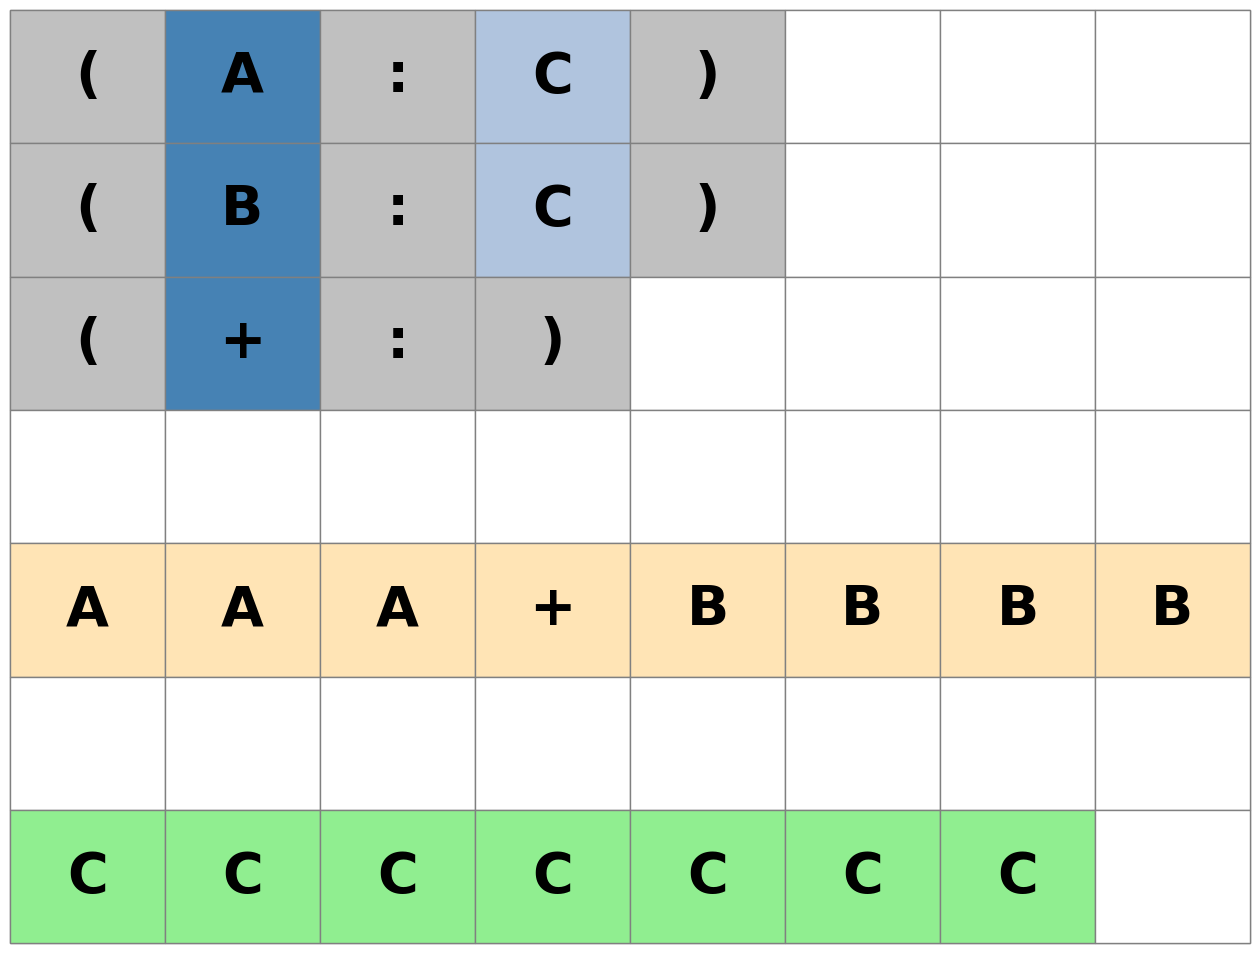

In [67]:
# Add
run("""
!EMPTY_TOKENS □
!SCALE 4

( A : C )
( B : C )
( + : )
□
A A A + B B B B
□
""")

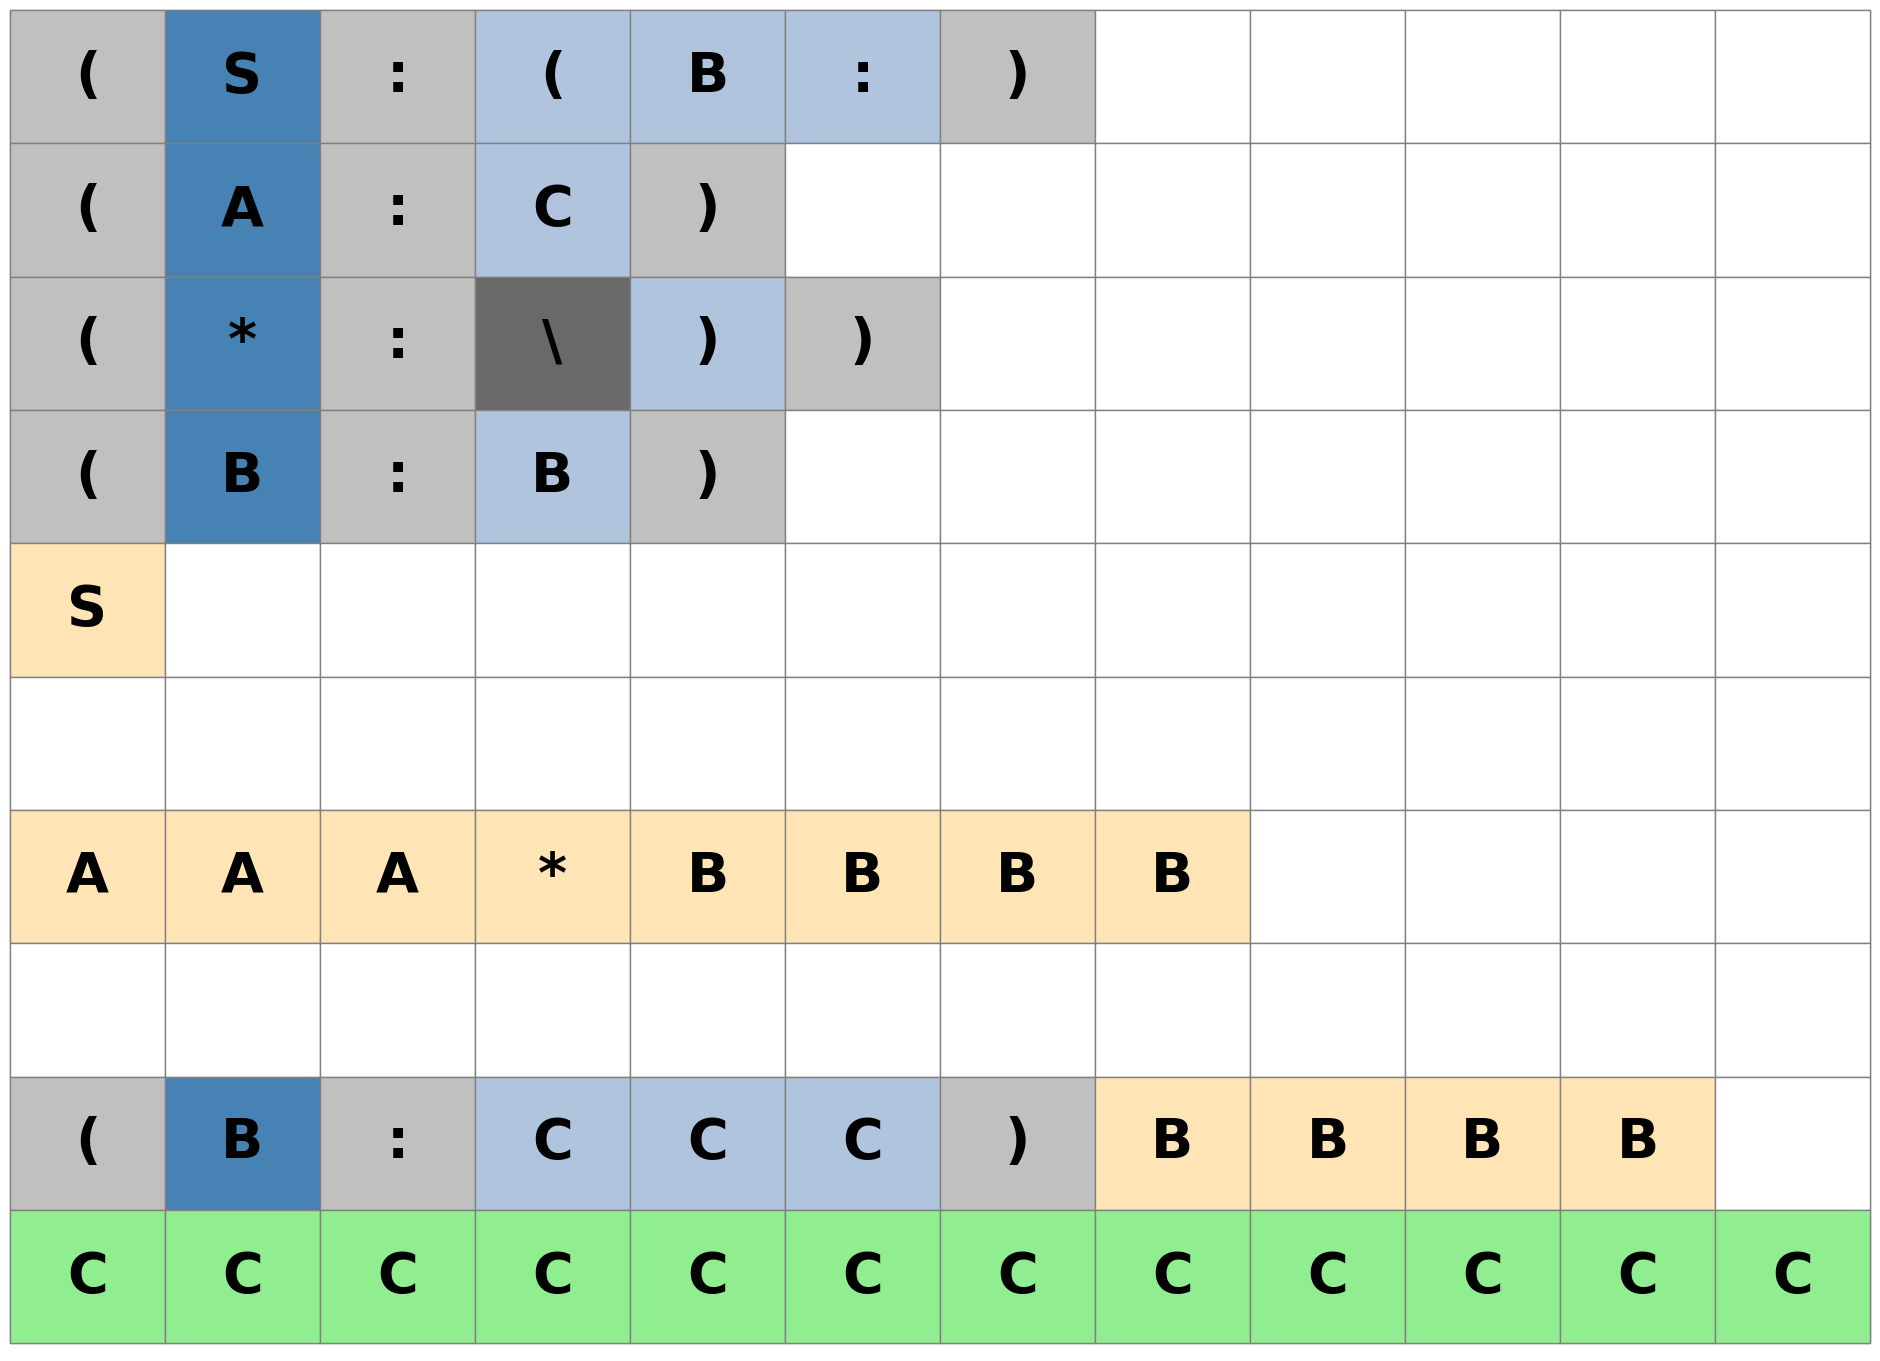

In [43]:
# Multiply
run("""
!EMPTY_TOKENS □
!SCALE 4

( S : ( B : )
( A : C )
( * : \ ) )
( B : B )
S
□
A A A * B B B B
□
""")

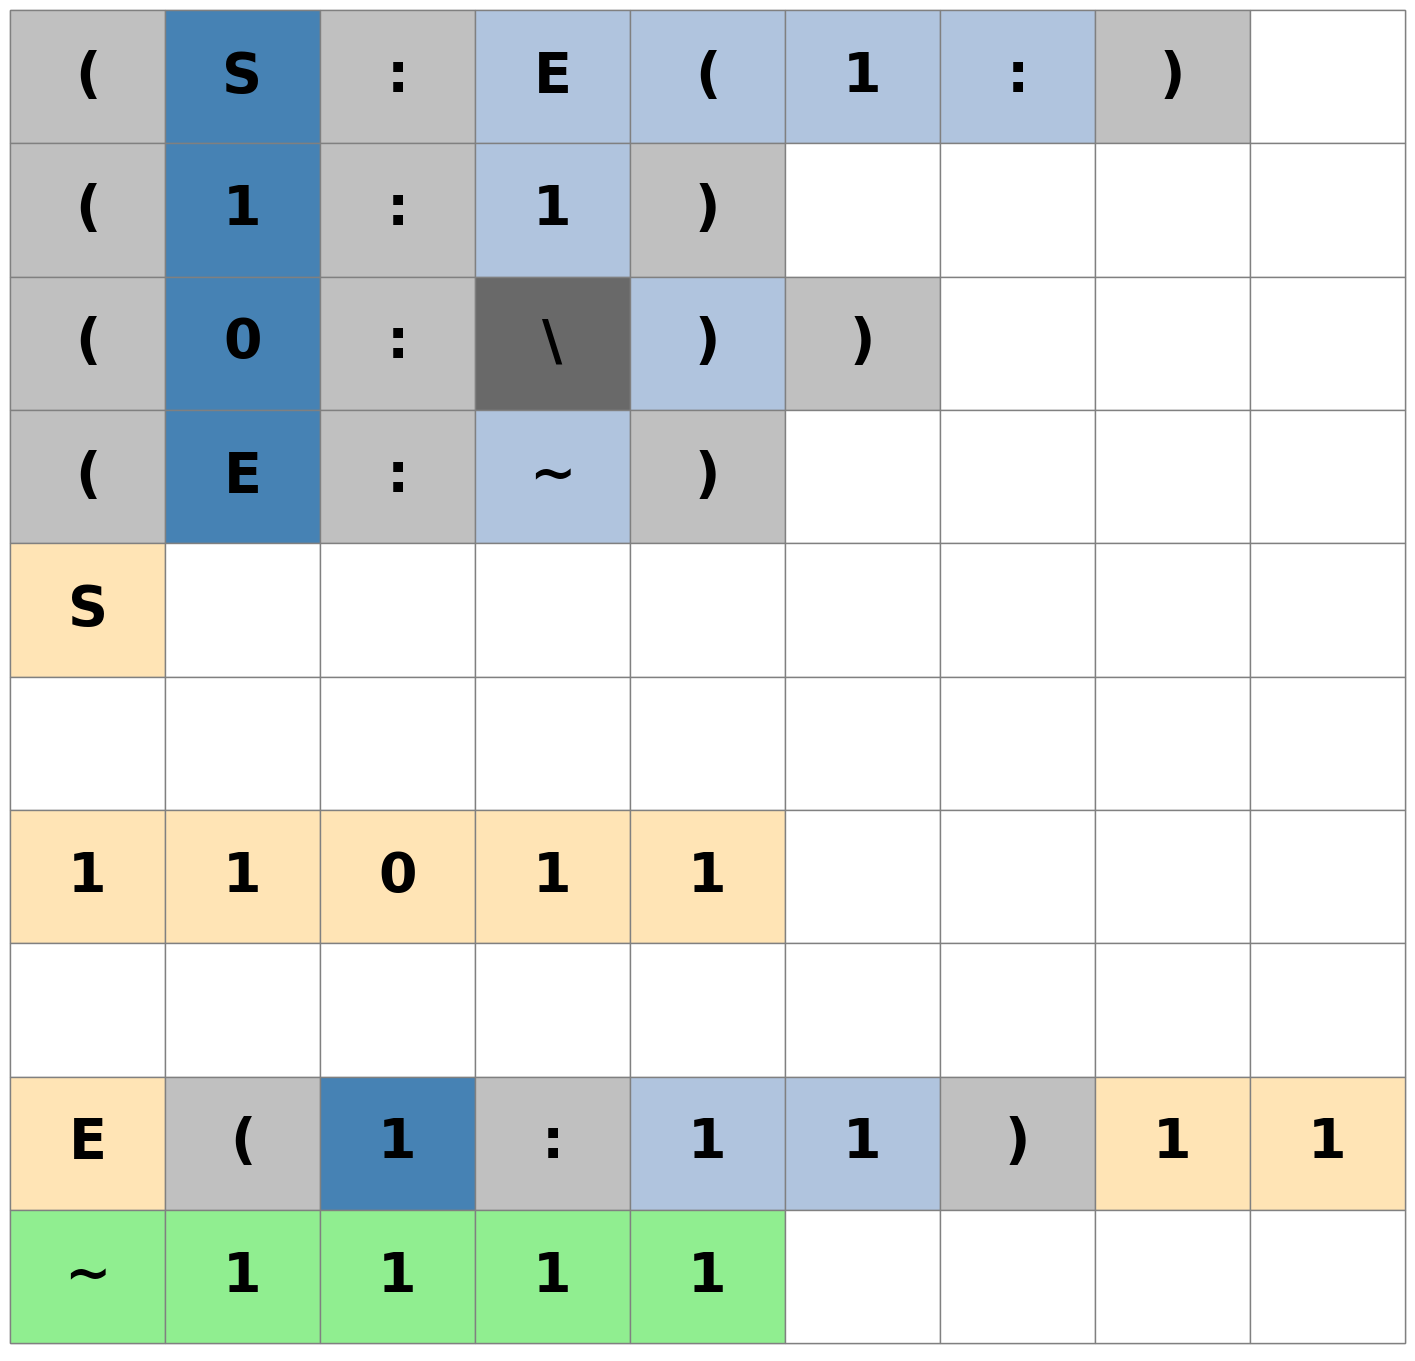

In [92]:
# Multiply only 0s and 1s
run("""
!EMPTY_TOKENS □
!SCALE 4

( S : E ( 1 : )
( 1 : 1 )
( 0 : \ ) )
( E : ~ )
S
□
1 1 0 1 1
□
""")

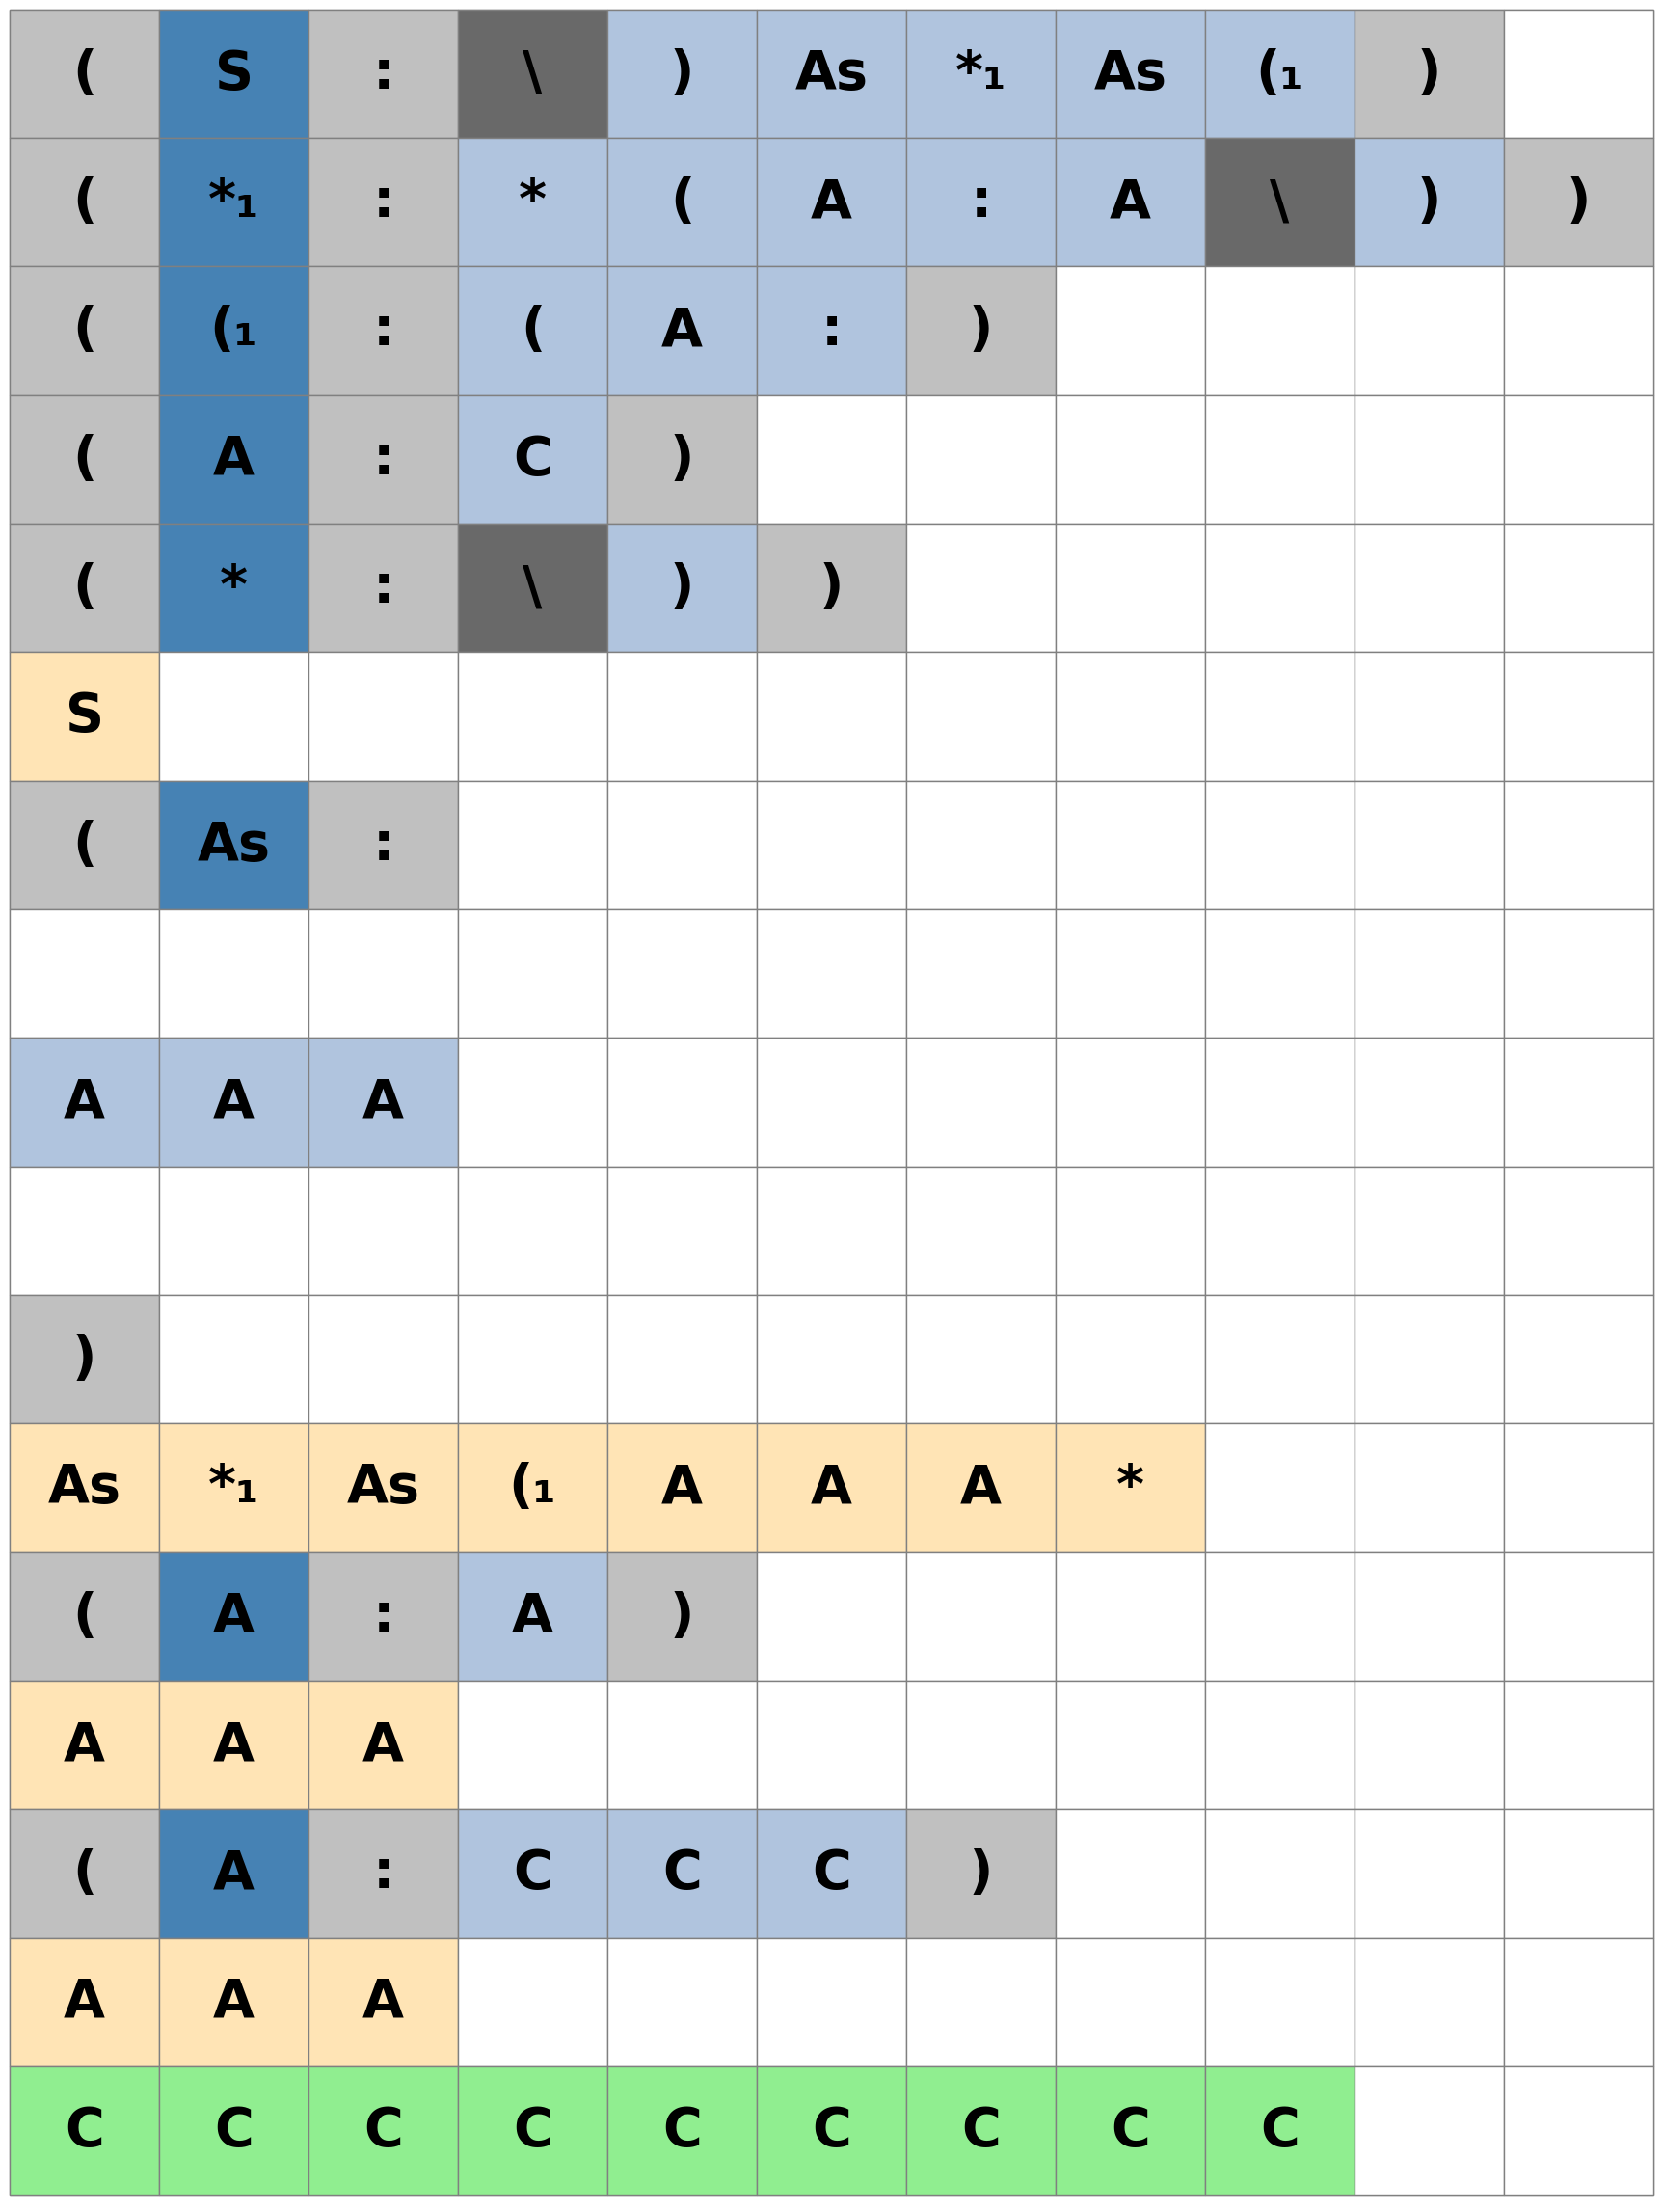

In [96]:
# Square
run("""
!EMPTY_TOKENS □
!NEWLINE_TOKENS ▣
!SCALE 4
!NEWLINE_RULES
!SKIP_IN_RULES □ ▣

( S : \ ) As *₁ As (₁ )
( *₁ : * ( A : A \ ) )
( (₁ : ( A : )
( A : C )
( * : \ ) )
S
( As :
▣ □ ▣
A A A
▣ □ ▣
""")

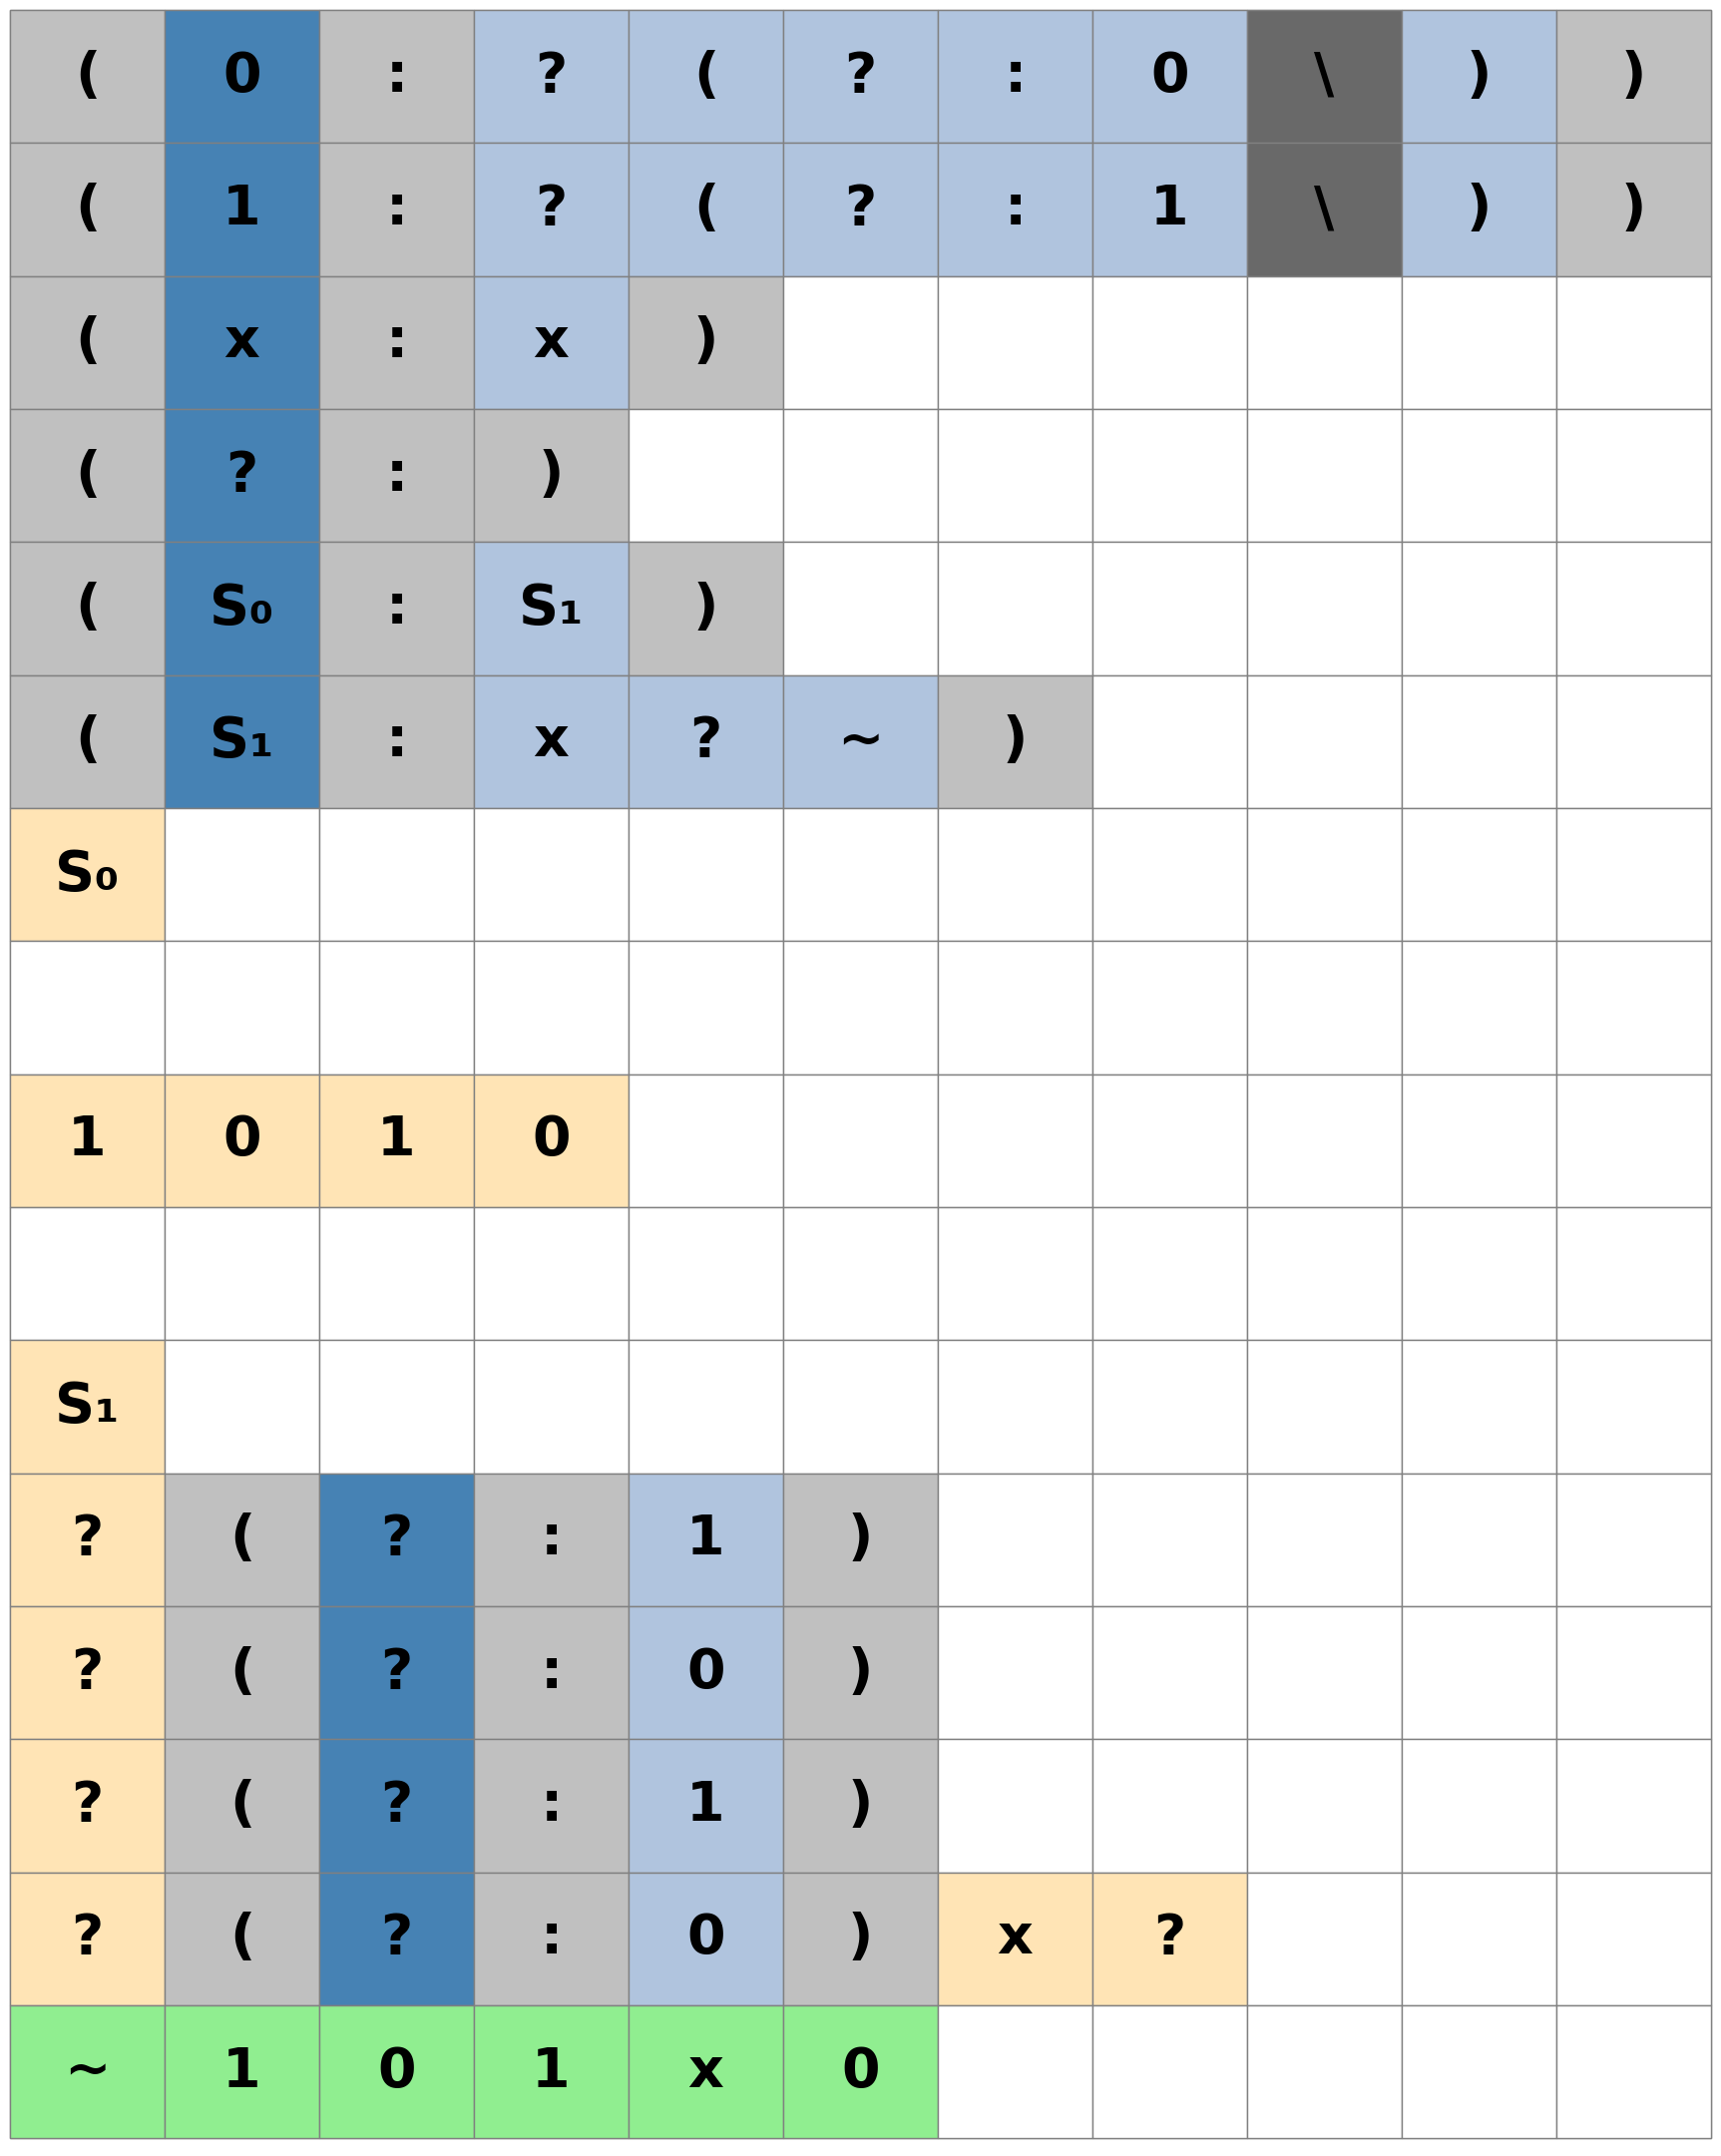

In [107]:
# Insert x before the last character (and ~ before the first character so the answer looks nice)
run("""
!SCALE 4
!EMPTY_TOKENS □
!NEWLINE_TOKENS ▣

( 0 : ▣ ? ( ? : 0 \ ) )
( 1 : ▣ ? ( ? : 1 \ ) )
( x : x )
( ? : )
( S₀ : S₁ )
( S₁ : x ? ~ )
S₀
□
1 0 1 0
□
""")

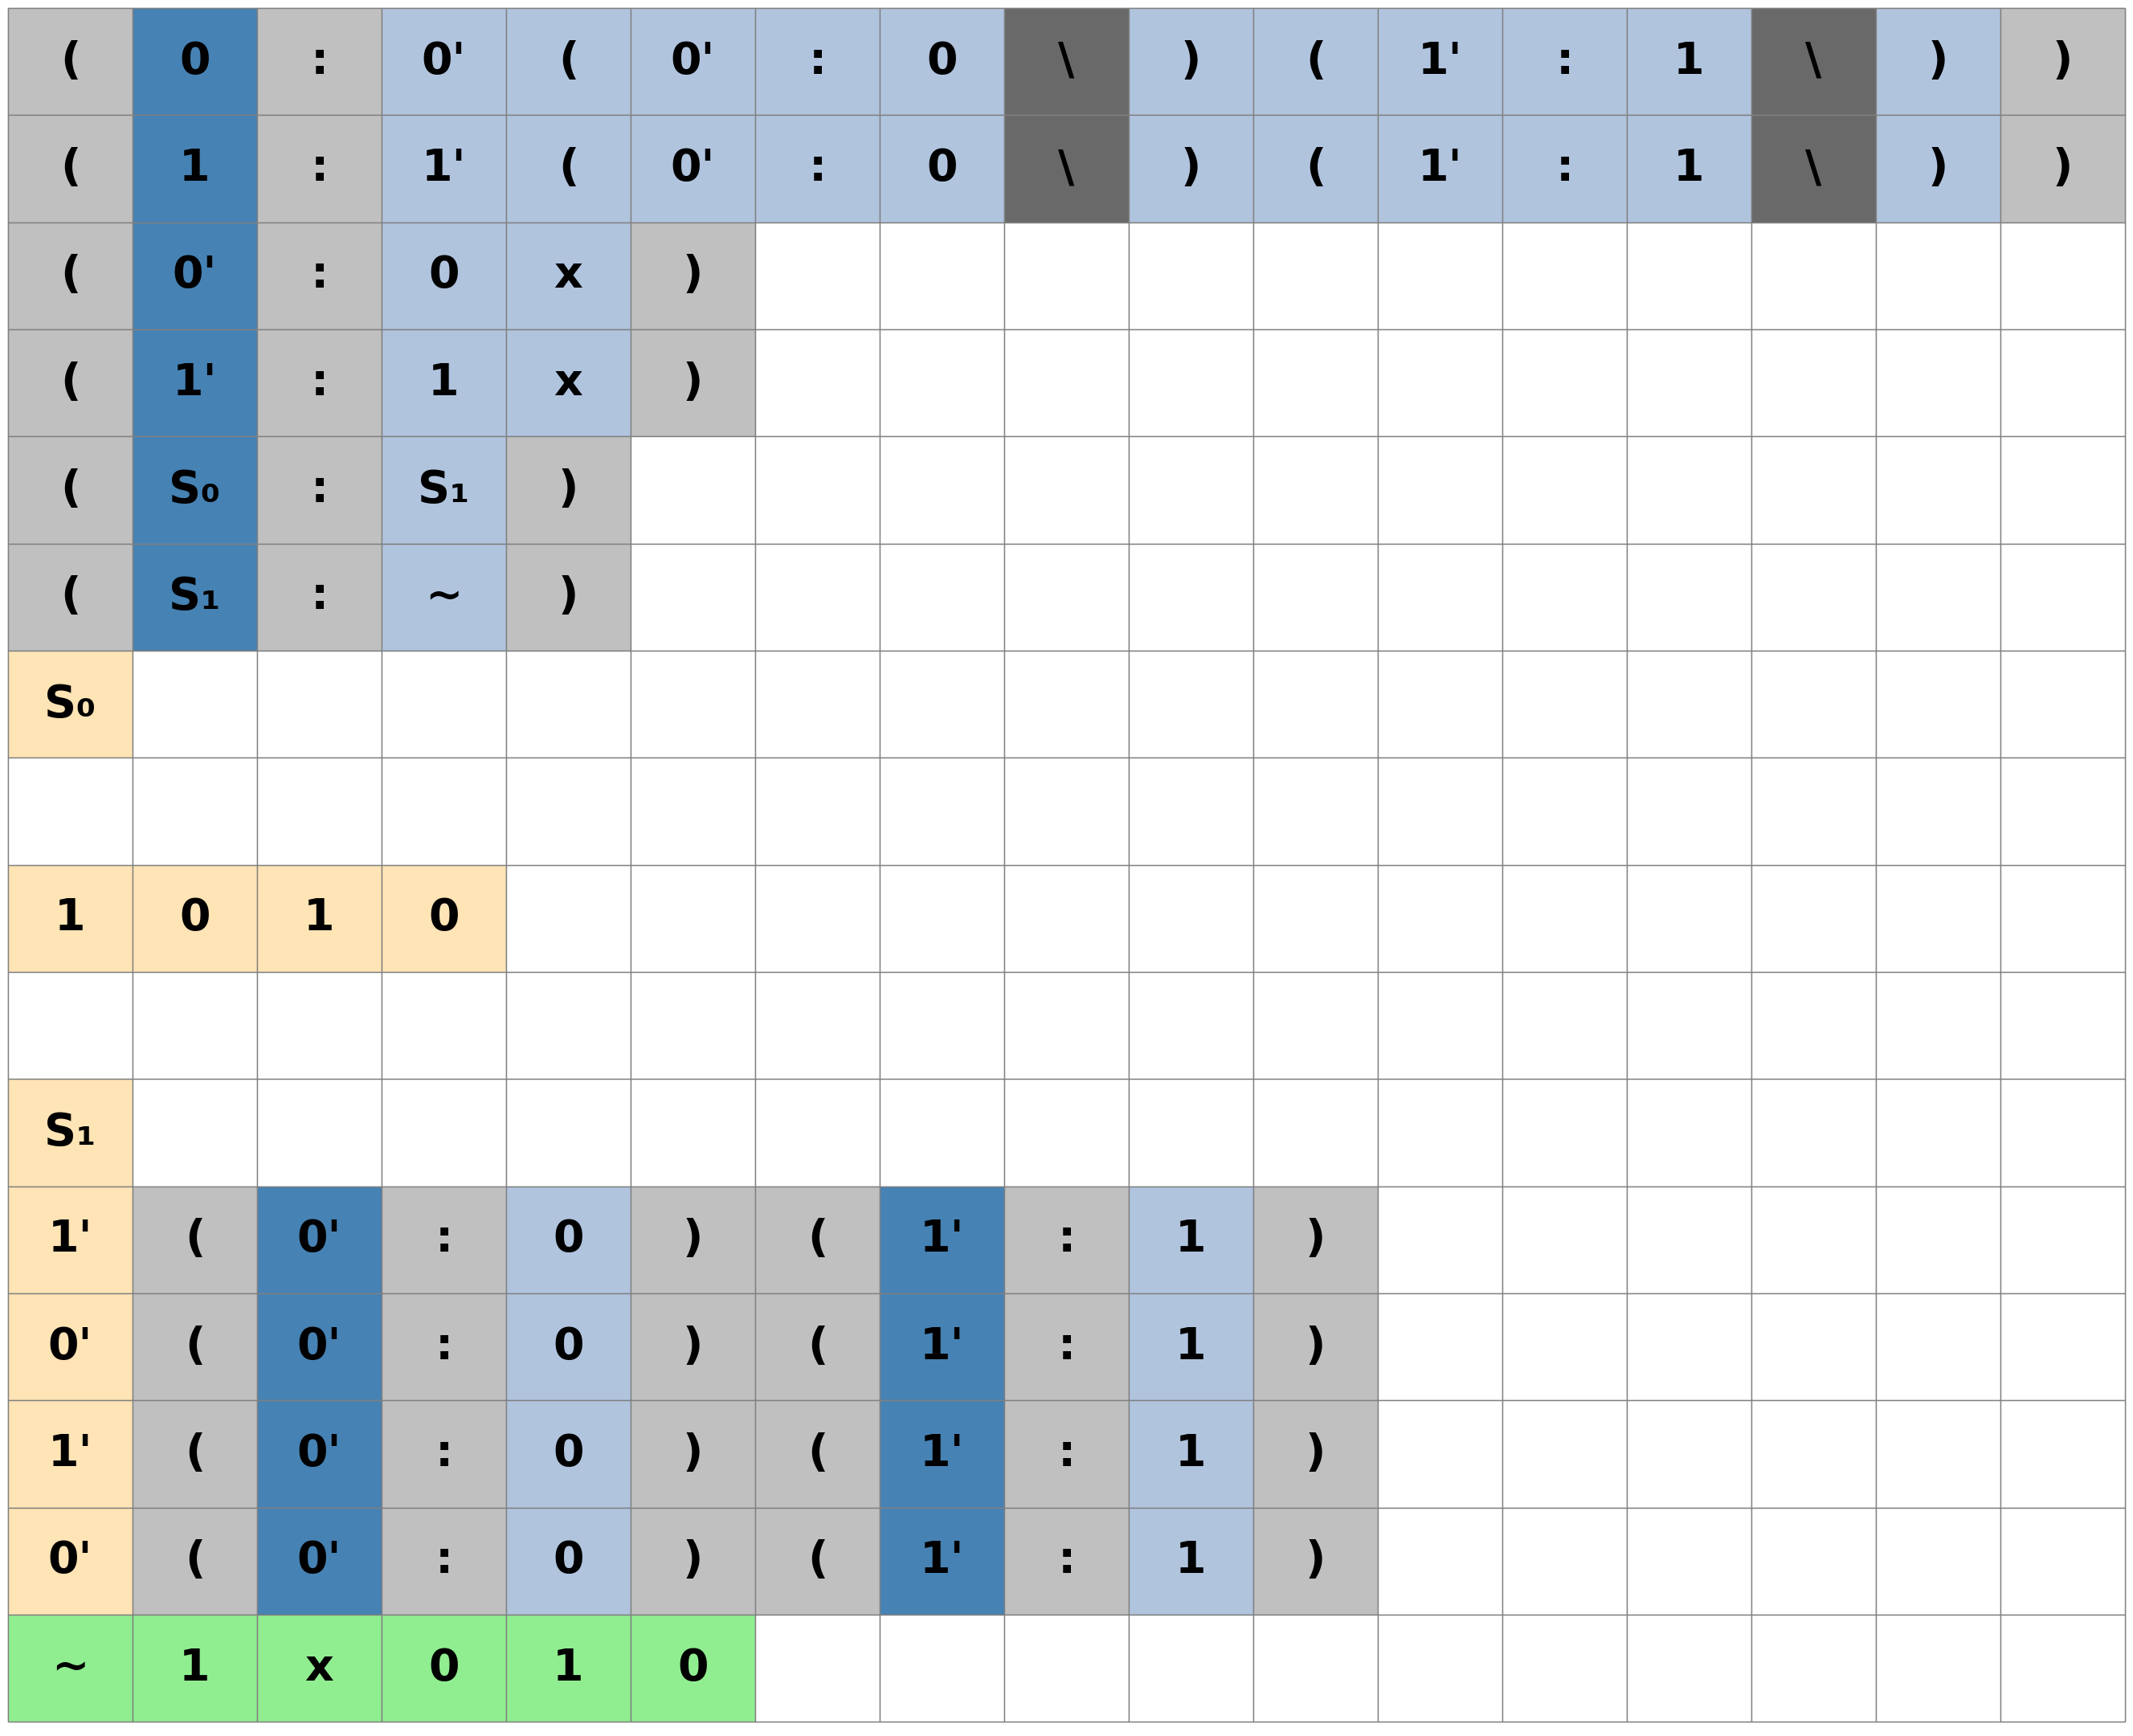

In [112]:
# Insert x after the first character (and ~ before the first character so the answer looks nice)
run("""
!SCALE 4
!EMPTY_TOKENS □
!NEWLINE_TOKENS ▣

( 0 : ▣ 0' ( 0' : 0 \ ) ( 1' : 1 \ ) )
( 1 : ▣ 1' ( 0' : 0 \ ) ( 1' : 1 \ ) )
( 0' : 0 x )
( 1' : 1 x )
( S₀ : S₁ )
( S₁ : ~ )
S₀
□
1 0 1 0
□
""")

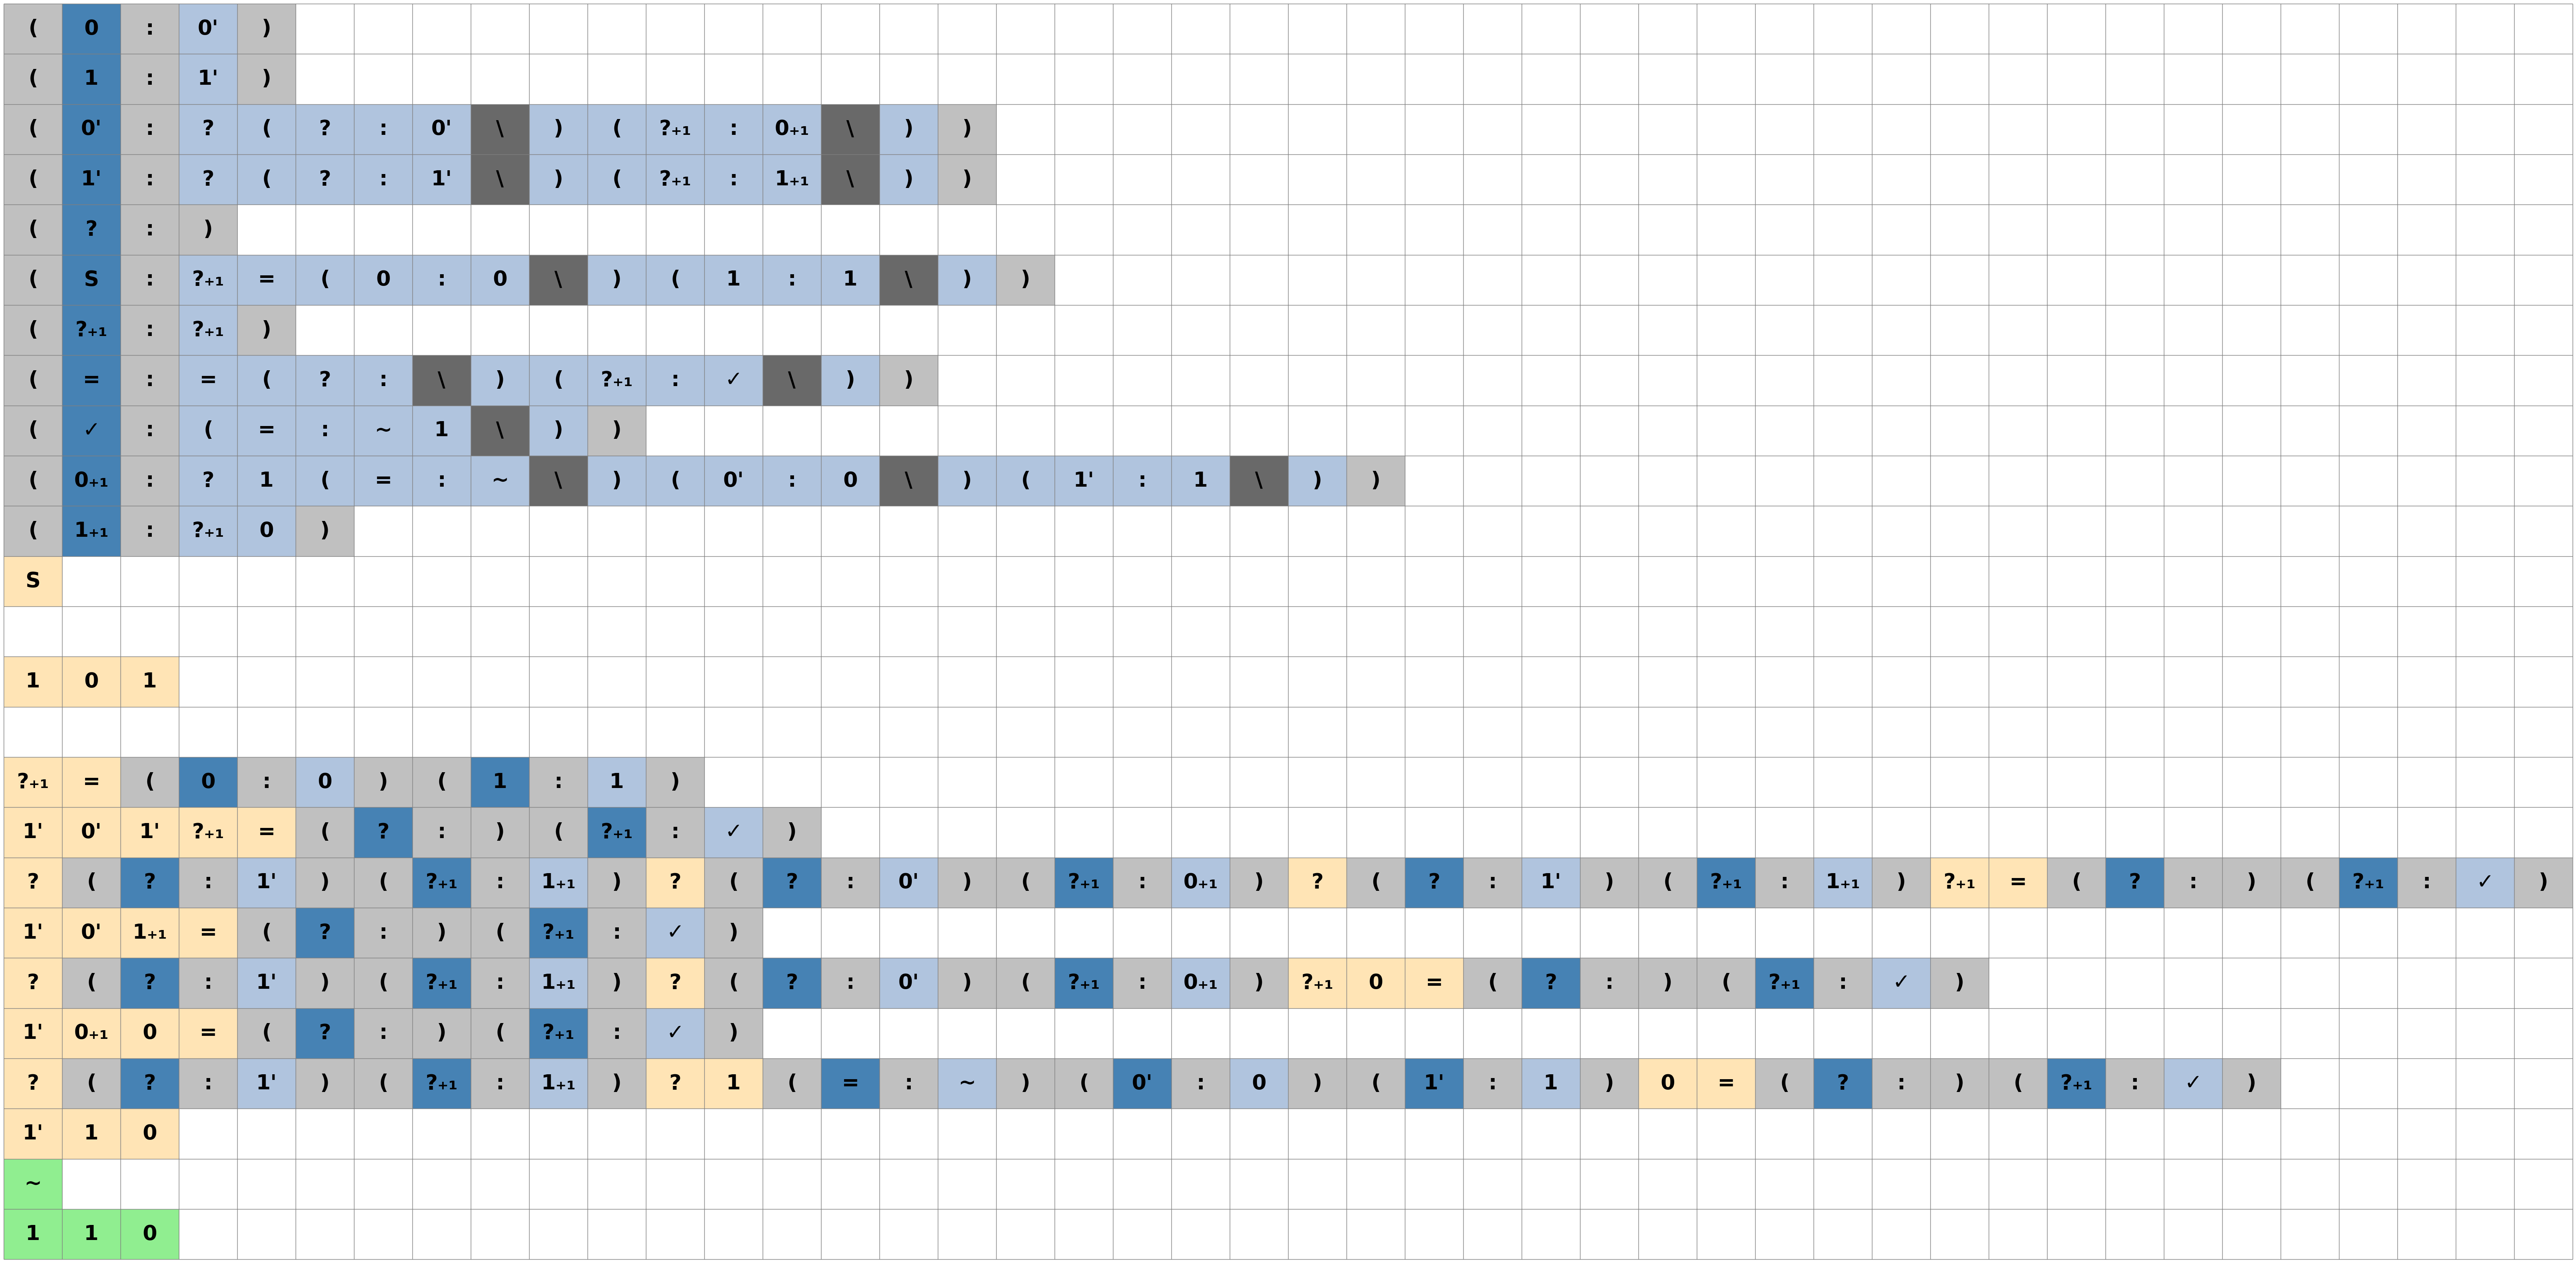

In [124]:
# Binary incrementation
run("""
!SCALE 4
!REPEAT ▣
!NEWLINE_TOKENS ▣ 
!EMPTY_TOKENS □

( 0 : 0' )
( 1 : 1' )
( 0' : ? ( ? : 0' \ ) ( ?₊₁ : 0₊₁ \ ) )
( 1' : ? ( ? : 1' \ ) ( ?₊₁ : 1₊₁ \ ) )
( ? : )
( S : ?₊₁ = ( 0 : 0 \ ) ( 1 : 1 \ ) )
( ?₊₁ : ?₊₁ )
( = : = ( ? : \ ) ( ?₊₁ : ✓ \ ) )
( ✓ : ( = : ~ 1 \ ) )
( 0₊₁ : ? 1 ( = : ~ \ ) ( 0' : 0 \ ) ( 1' : 1 \ ) )
( 1₊₁ : ?₊₁ 0 )
S
□
▣ 1 0 1
□
""")

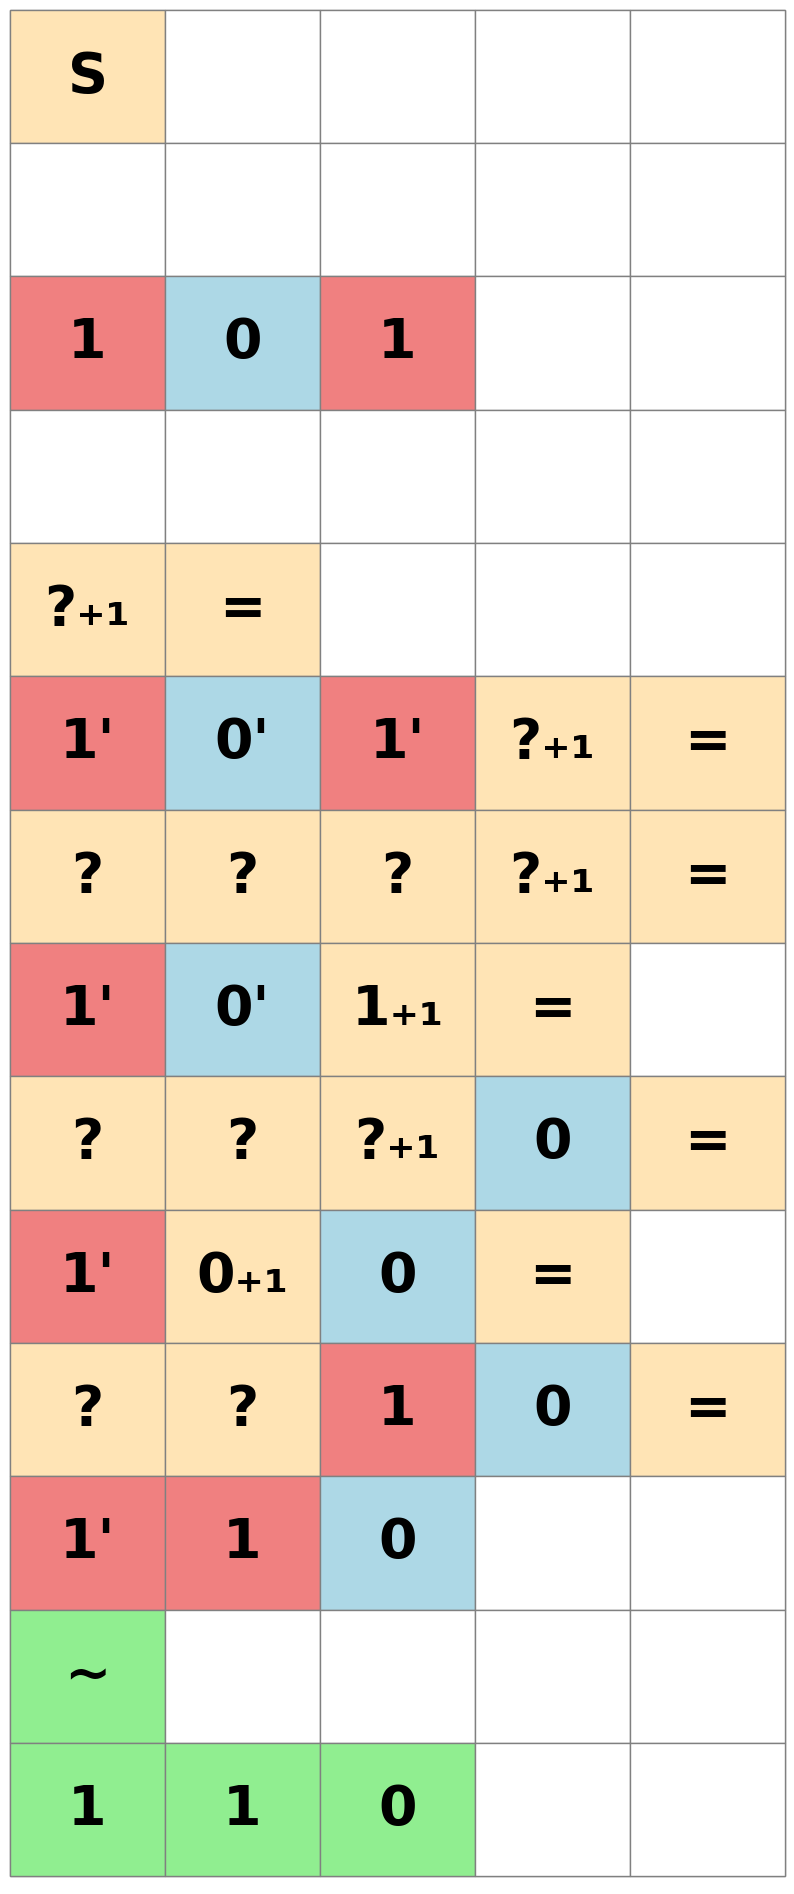

In [126]:
# Binary incrementation
run("""
!SCALE 4
!REPEAT ▣
!NEWLINE_TOKENS ▣ 
!EMPTY_TOKENS □
!SKIP_RULES
!HIGHLIGHT(lightblue) 0 0'
!HIGHLIGHT(lightcoral) 1 1'

( 0 : 0' )
( 1 : 1' )
( 0' : ? ( ? : 0' \ ) ( ?₊₁ : 0₊₁ \ ) )
( 1' : ? ( ? : 1' \ ) ( ?₊₁ : 1₊₁ \ ) )
( ? : )
( S : ?₊₁ = ( 0 : 0 \ ) ( 1 : 1 \ ) )
( ?₊₁ : ?₊₁ )
( = : = ( ? : \ ) ( ?₊₁ : ✓ \ ) )
( ✓ : ( = : ~ 1 \ ) )
( 0₊₁ : ? 1 ( = : ~ \ ) ( 0' : 0 \ ) ( 1' : 1 \ ) )
( 1₊₁ : ?₊₁ 0 )
S
□
▣ 1 0 1
□
""")

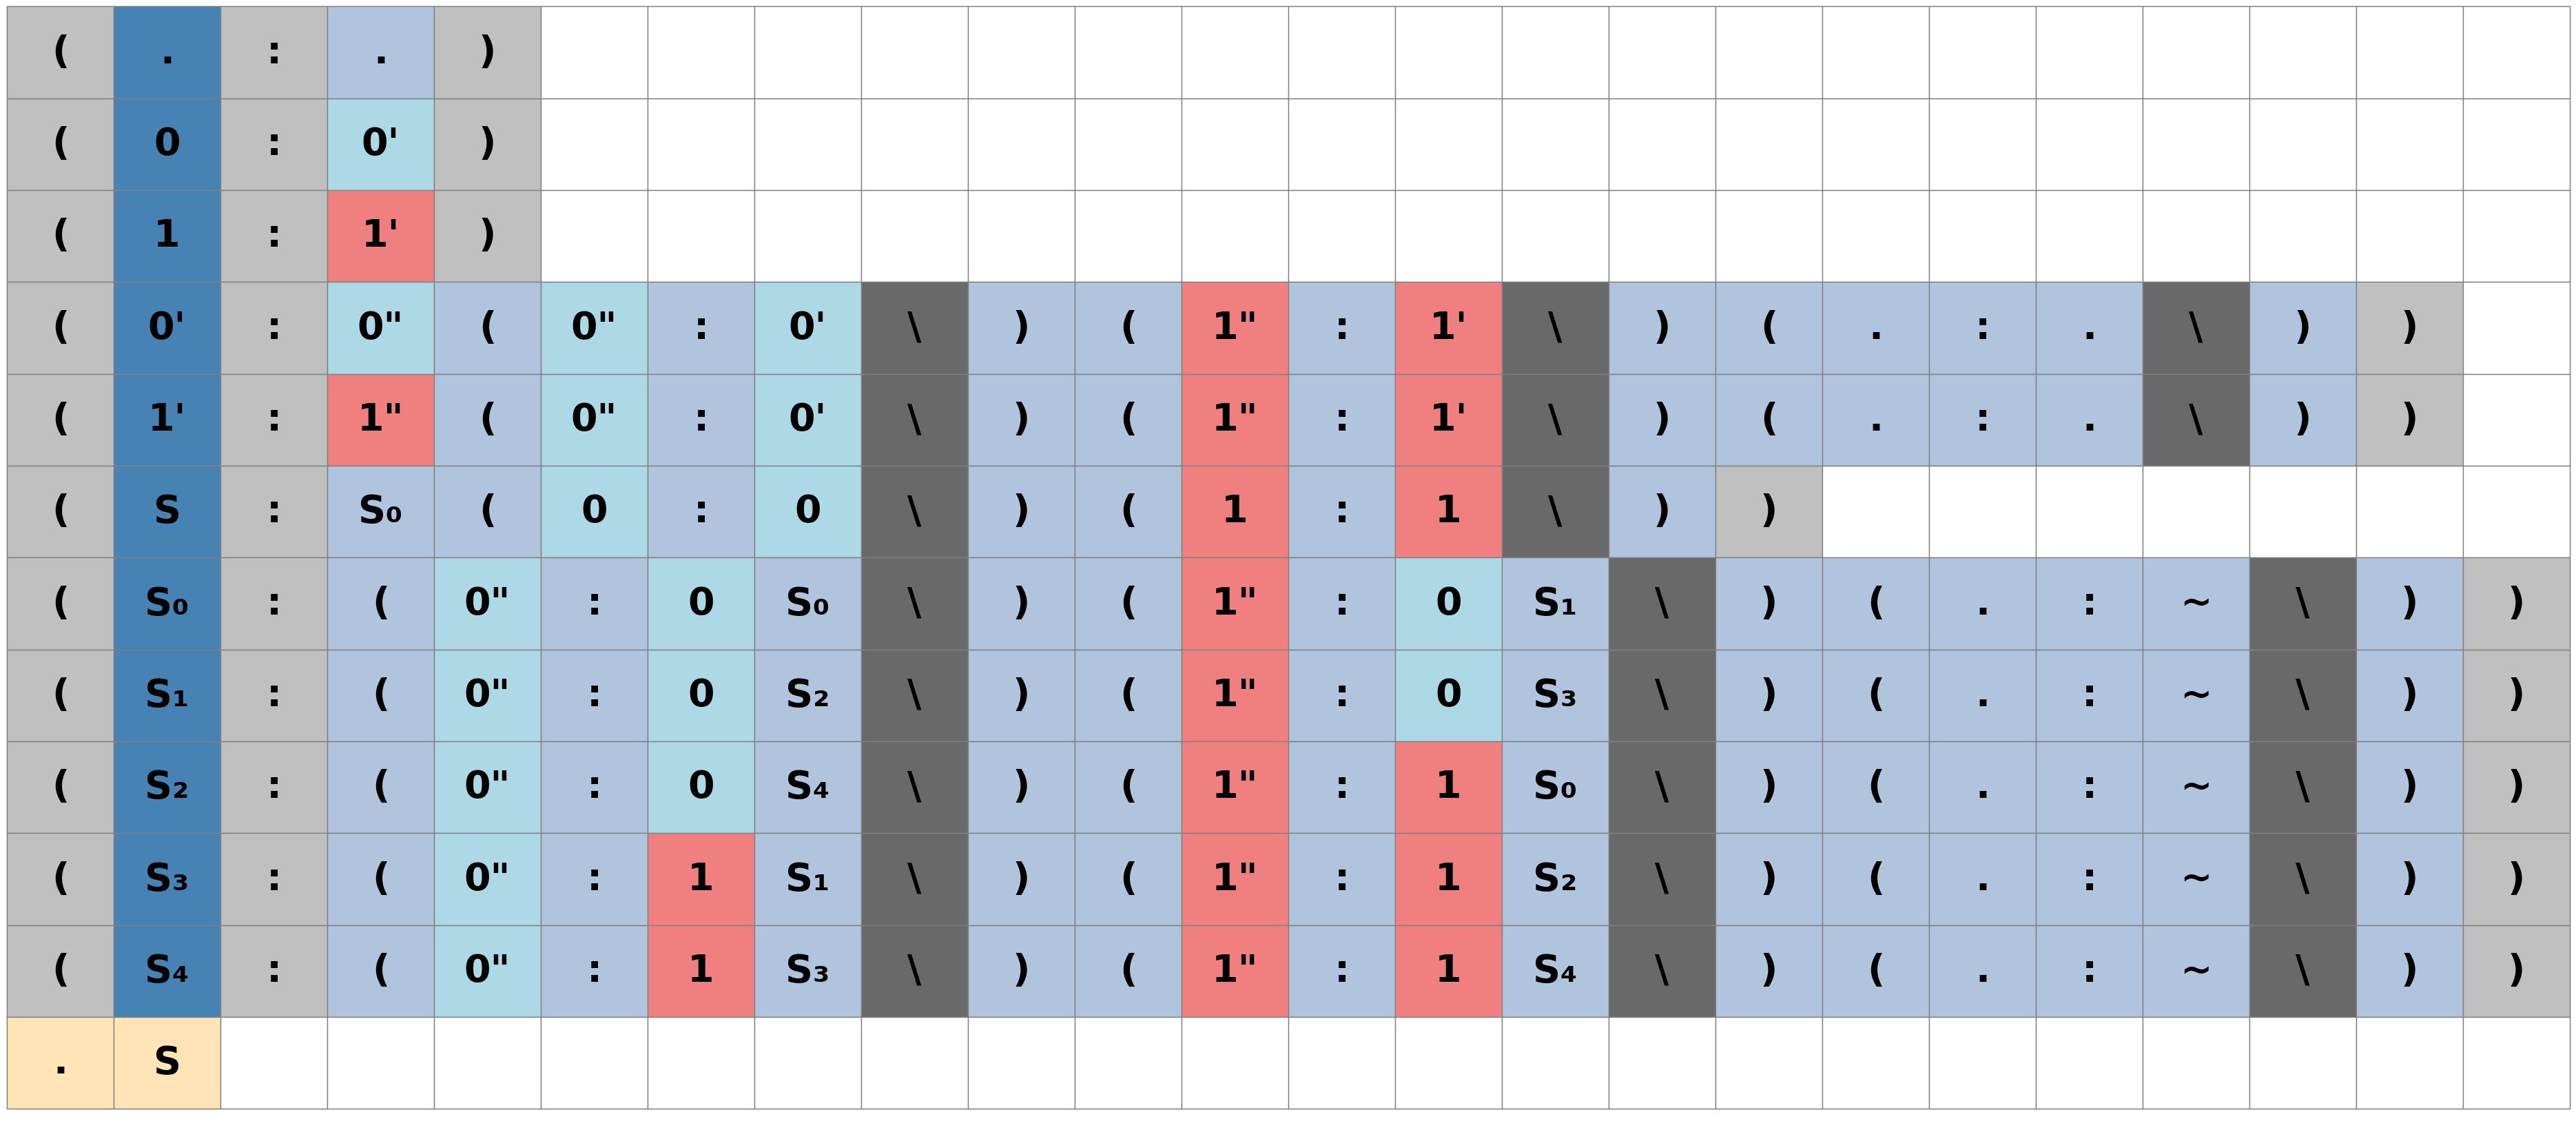

In [91]:
# FSM homework 2
run("""
# start = S₀
# (S₀) 0 --> S₀, 1 --> S₁
# (S₁) 0 --> S₂, 1 --> S₃
# (S₂) 0 --> S₄, 1 --> S₀
# (S₃) 0 --> S₁, 1 --> S₂
# (S₄) 0 --> S₃, 1 --> S₄
# accepting = S₀

!SCALE 4
!REPEAT ▣ 
!NEWLINE_TOKENS ▣
!EMPTY_TOKENS □
!HIGHLIGHT(lightblue) 0 0' 0"
!HIGHLIGHT(lightcoral) 1 1' 1"
!HIGHLIGHT_IN_RULES
!LIMIT 230

( . : . )
( 0 : 0' )
( 1 : 1' )
( 0' : 0" ( 0" : 0' \ ) ( 1" : 1' \ ) ( . : . \ ) ) 
( 1' : 1" ( 0" : 0' \ ) ( 1" : 1' \ ) ( . : . \ ) ) 

( S : S₀ ( 0 : 0 \ ) ( 1 : 1 \ ) )

( S₀ : □ ( 0" : 0 S₀ \ ) ( 1" : 0 S₁ \ ) ( . : ~ \ ) )
( S₁ : □ ( 0" : 0 S₂ \ ) ( 1" : 0 S₃ \ ) ( . : ~ \ ) )
( S₂ : □ ( 0" : 0 S₄ \ ) ( 1" : 1 S₀ \ ) ( . : ~ \ ) )
( S₃ : □ ( 0" : 1 S₁ \ ) ( 1" : 1 S₂ \ ) ( . : ~ \ ) )
( S₄ : □ ( 0" : 1 S₃ \ ) ( 1" : 1 S₄ \ ) ( . : ~ \ ) )

. S
""")

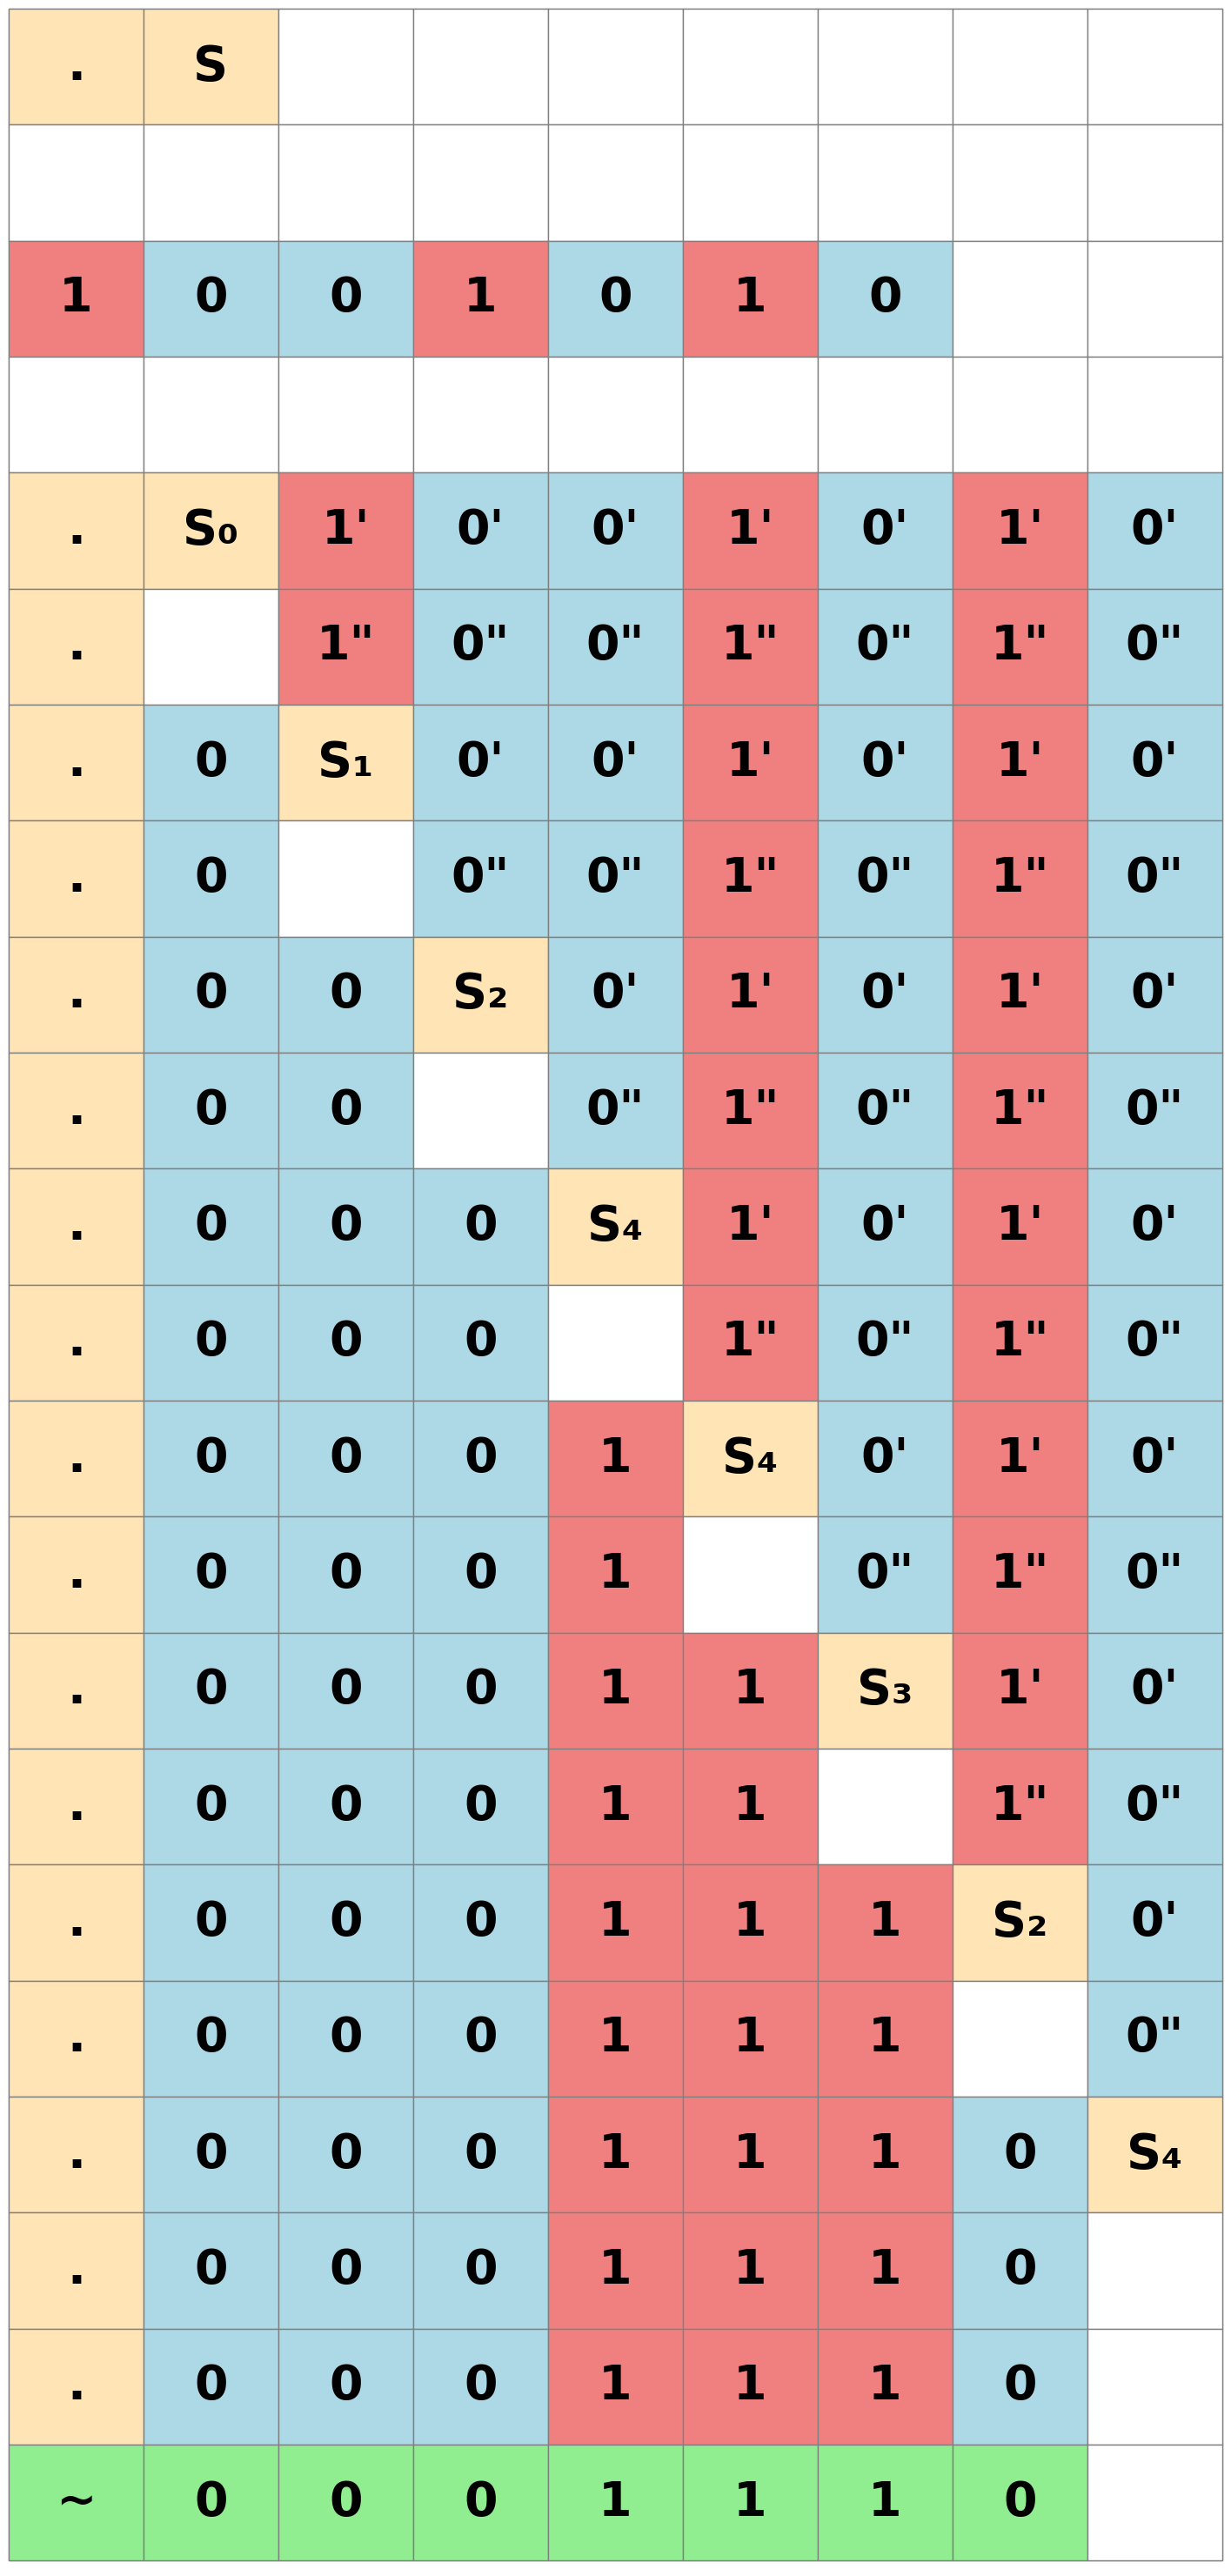

In [81]:
# FSM homework 1
run("""
# start = S₀
# (S₀) 0 --> S₀, 1 --> S₁
# (S₁) 0 --> S₂, 1 --> S₃
# (S₂) 0 --> S₄, 1 --> S₀
# (S₃) 0 --> S₁, 1 --> S₂
# (S₄) 0 --> S₃, 1 --> S₄
# accepting = S₀

!SCALE 4
!SKIP_RULES
!REPEAT ▣ 
!NEWLINE_TOKENS ▣
!EMPTY_TOKENS □
!HIGHLIGHT(lightblue) 0 0' 0"
!HIGHLIGHT(lightcoral) 1 1' 1"

( . : . )
( 0 : 0' )
( 1 : 1' )
( 0' : 0" ( 0" : 0' \ ) ( 1" : 1' \ ) ( . : . \ ) ) 
( 1' : 1" ( 0" : 0' \ ) ( 1" : 1' \ ) ( . : . \ ) ) 

( S : S₀ ( 0 : 0 \ ) ( 1 : 1 \ ) )

( S₀ : □ ( 0" : 0 S₀ \ ) ( 1" : 0 S₁ \ ) ( . : ~ \ ) )
( S₁ : □ ( 0" : 0 S₂ \ ) ( 1" : 0 S₃ \ ) ( . : ~ \ ) )
( S₂ : □ ( 0" : 0 S₄ \ ) ( 1" : 1 S₀ \ ) ( . : ~ \ ) )
( S₃ : □ ( 0" : 1 S₁ \ ) ( 1" : 1 S₂ \ ) ( . : ~ \ ) )
( S₄ : □ ( 0" : 1 S₃ \ ) ( 1" : 1 S₄ \ ) ( . : ~ \ ) )

. S
□
1 0 0 1 0 1 0 ▣
□
""")

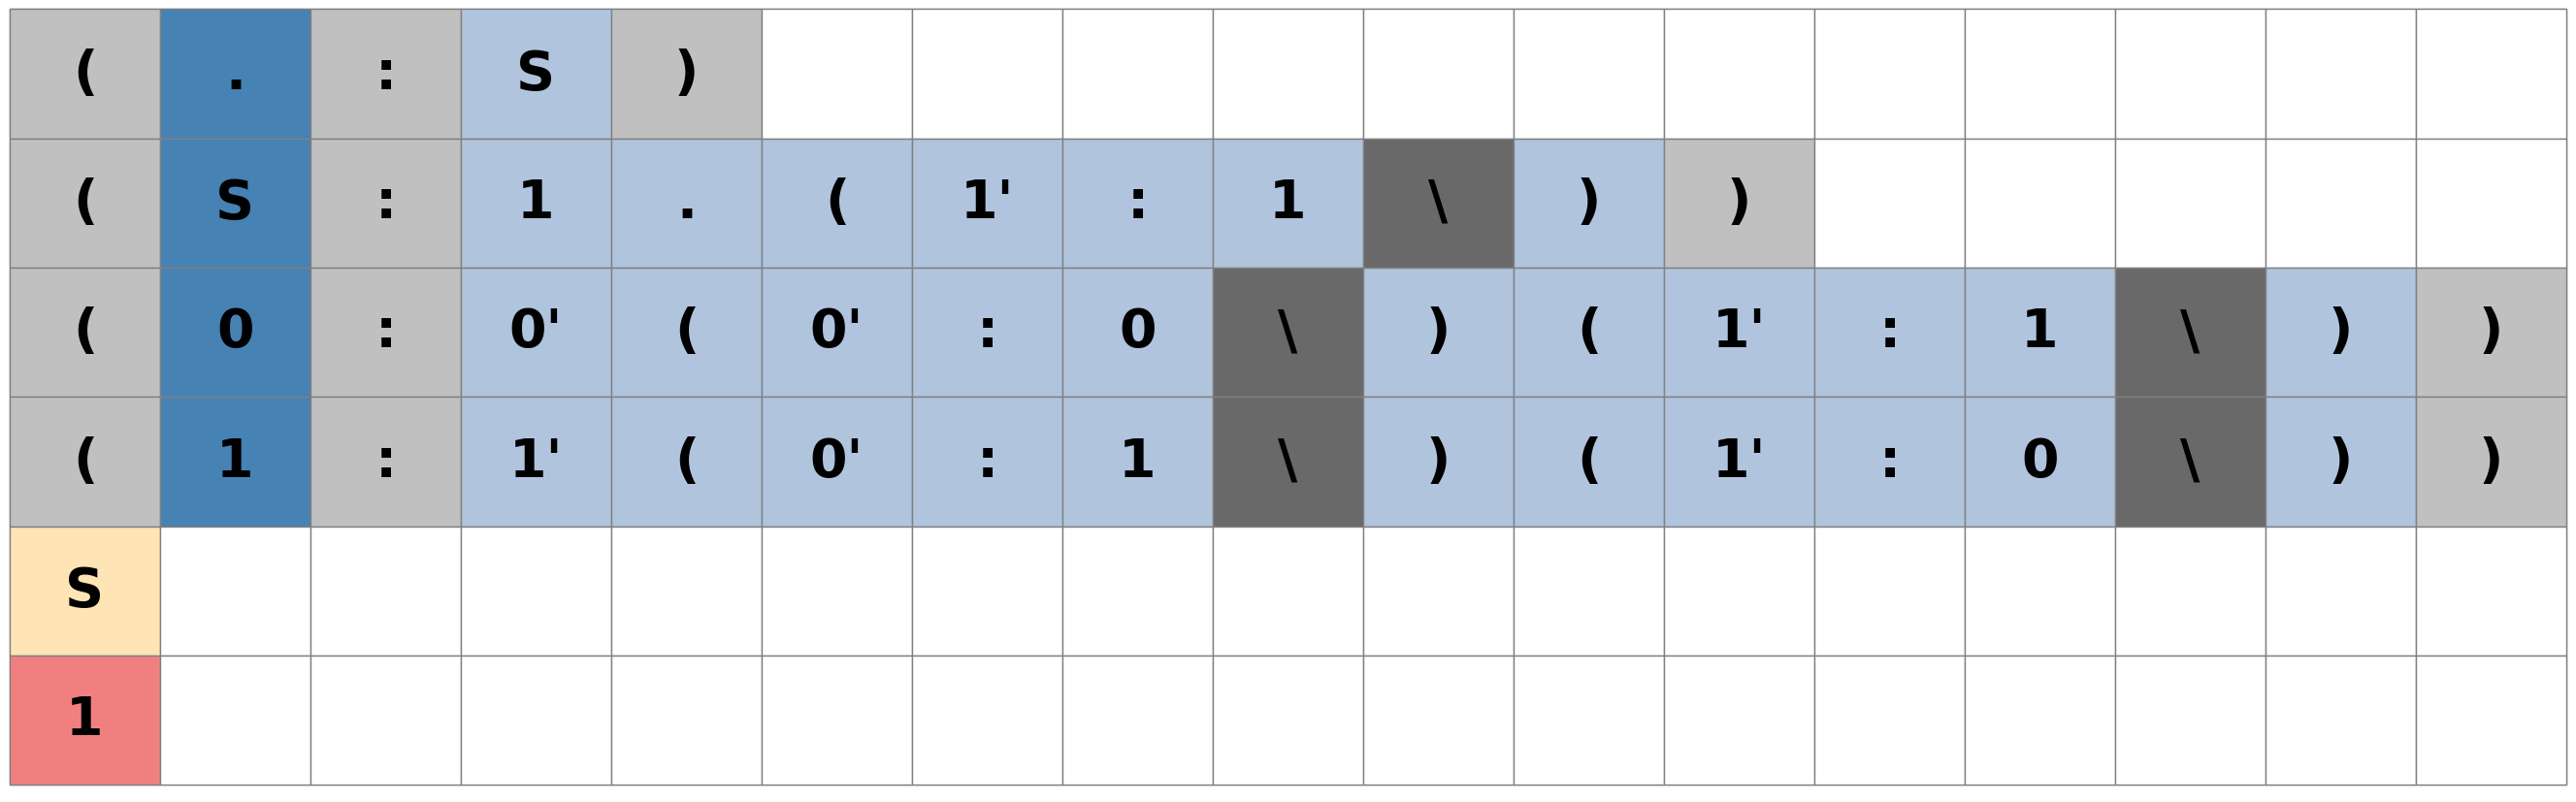

In [71]:
# Sierpinski Triangle
run("""
!SCALE 4
!NEWLINE_TOKENS □
!LIMIT 61
!HIGHLIGHT(lightblue) 0
!HIGHLIGHT(lightcoral) 1

( . : S □ )
( S : 1 . ( 1' : 1 \ ) )
( 0 : 0' ( 0' : 0 \ ) ( 1' : 1 \ ) )
( 1 : 1' ( 0' : 1 \ ) ( 1' : 0 \ ) )
S
""")

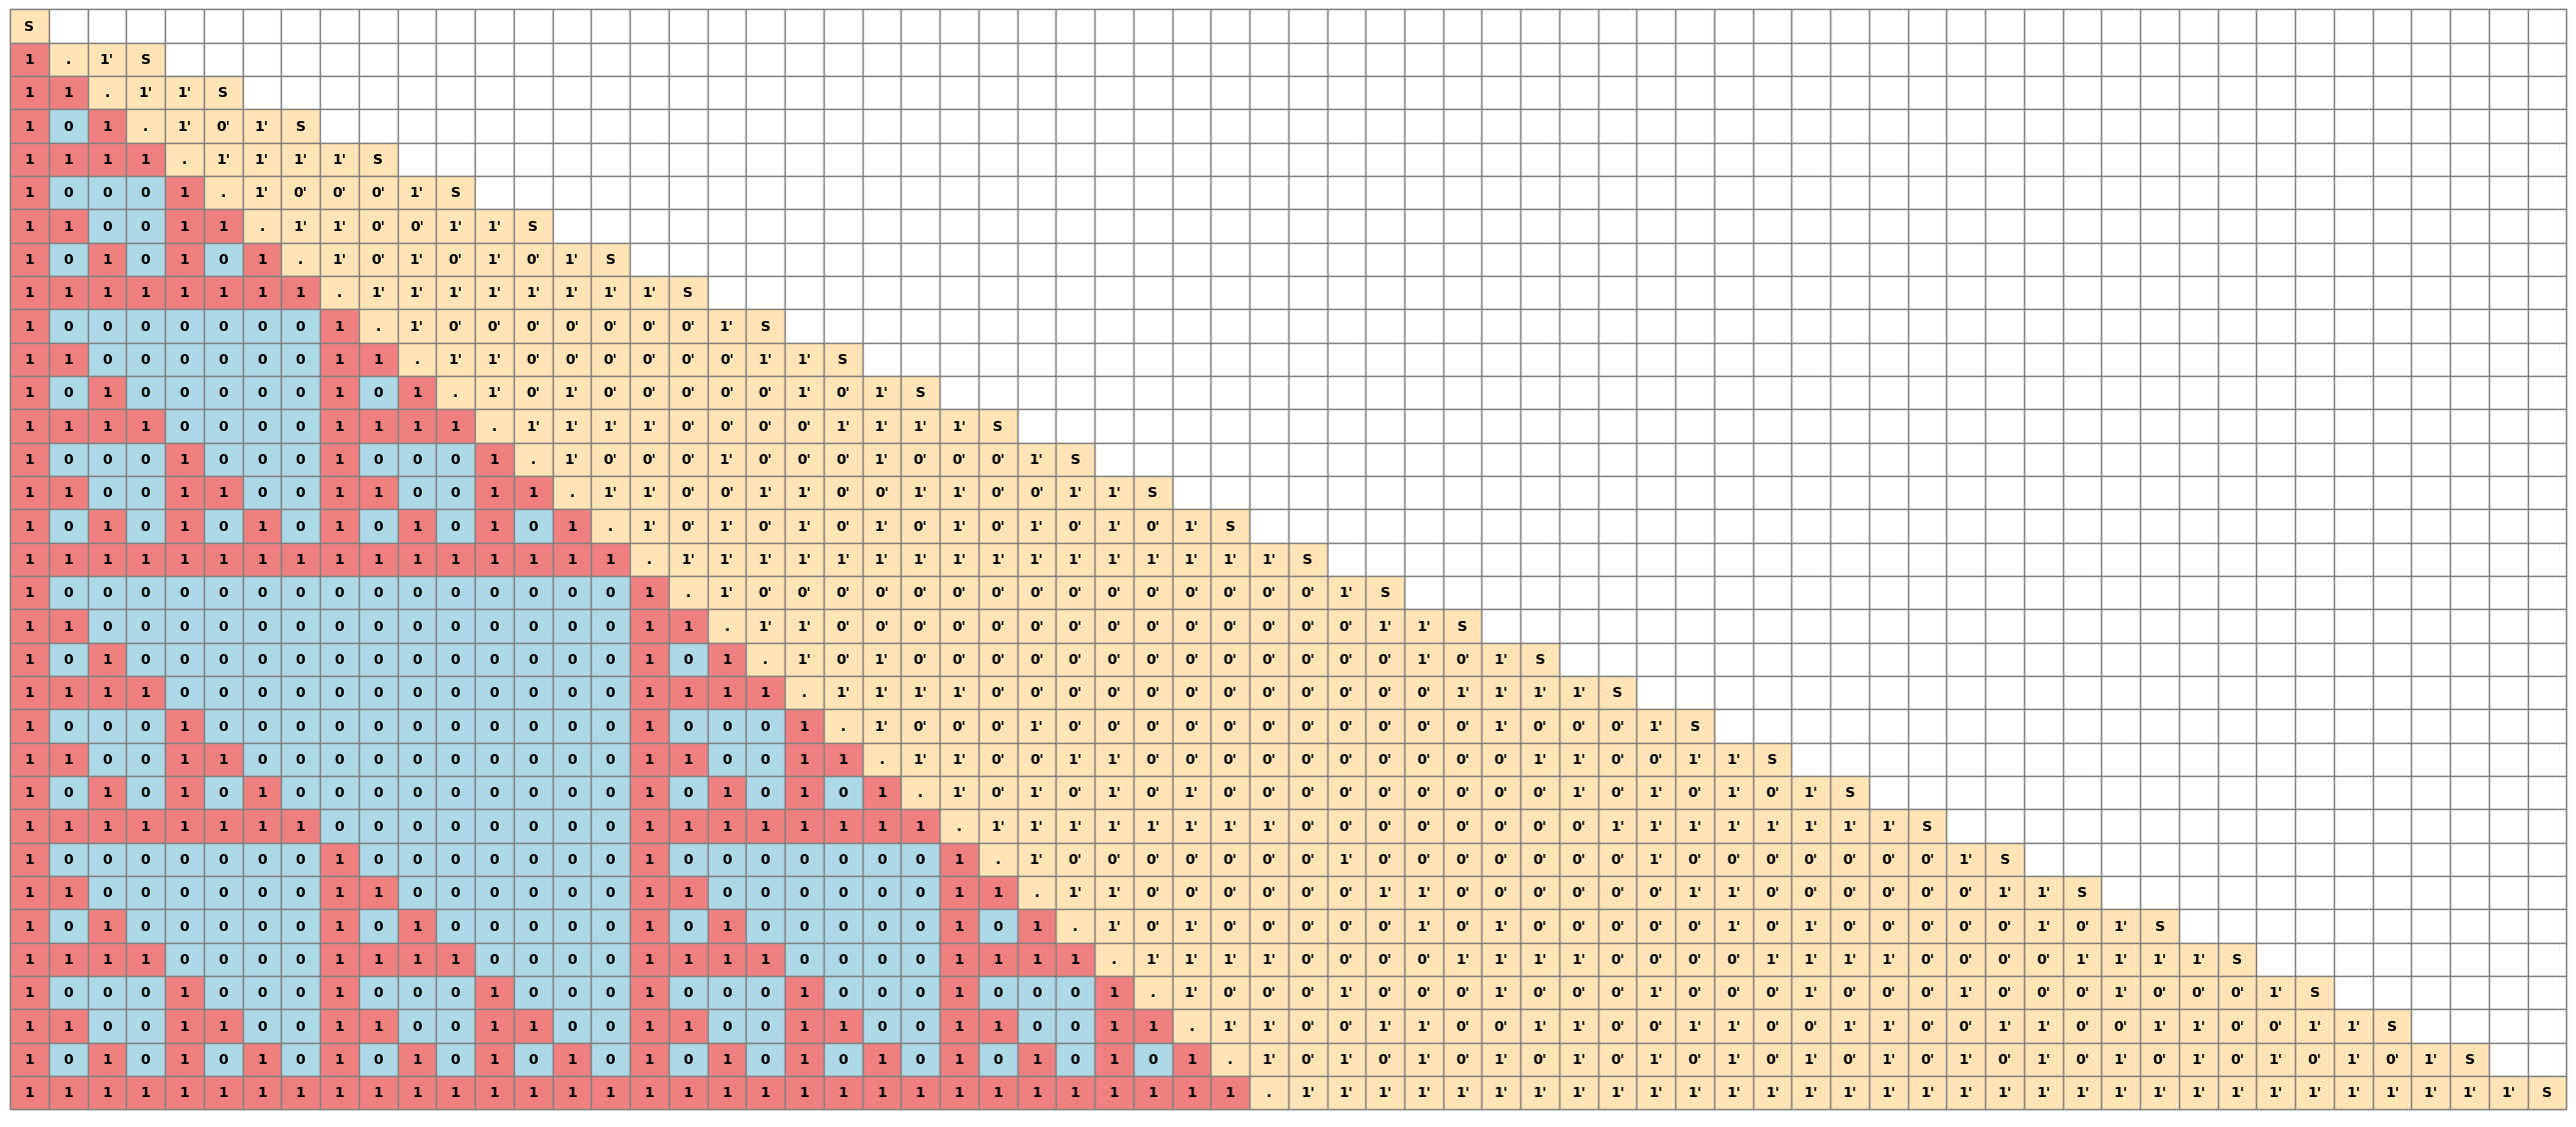

In [50]:
# Sierpinski Triangle
run("""
!SKIP_RULES
!NEWLINE_TOKENS □
!LIMIT 6652
!HIGHLIGHT(lightblue) 0
!HIGHLIGHT(lightcoral) 1

( . : S □ )
( S : 1 . ( 1' : 1 \ ) )
( 0 : 0' ( 0' : 0 \ ) ( 1' : 1 \ ) )
( 1 : 1' ( 0' : 1 \ ) ( 1' : 0 \ ) )
S
""")

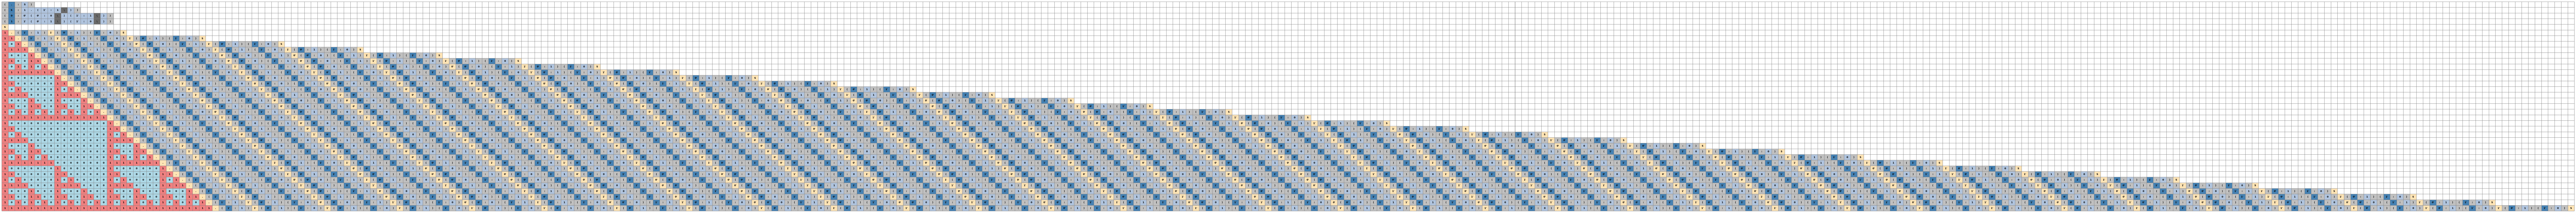

In [127]:
# Sierpinski Triangle
run("""
!NEWLINE_TOKENS □
!LIMIT 6652
!HIGHLIGHT(lightblue) 0
!HIGHLIGHT(lightcoral) 1

( . : S □ )
( S : 1 . ( 1' : 1 \ ) )
( 0 : 0' ( 0' : 0 \ ) ( 1' : 1 \ ) )
( 1 : 1' ( 0' : 1 \ ) ( 1' : 0 \ ) )
S
""")

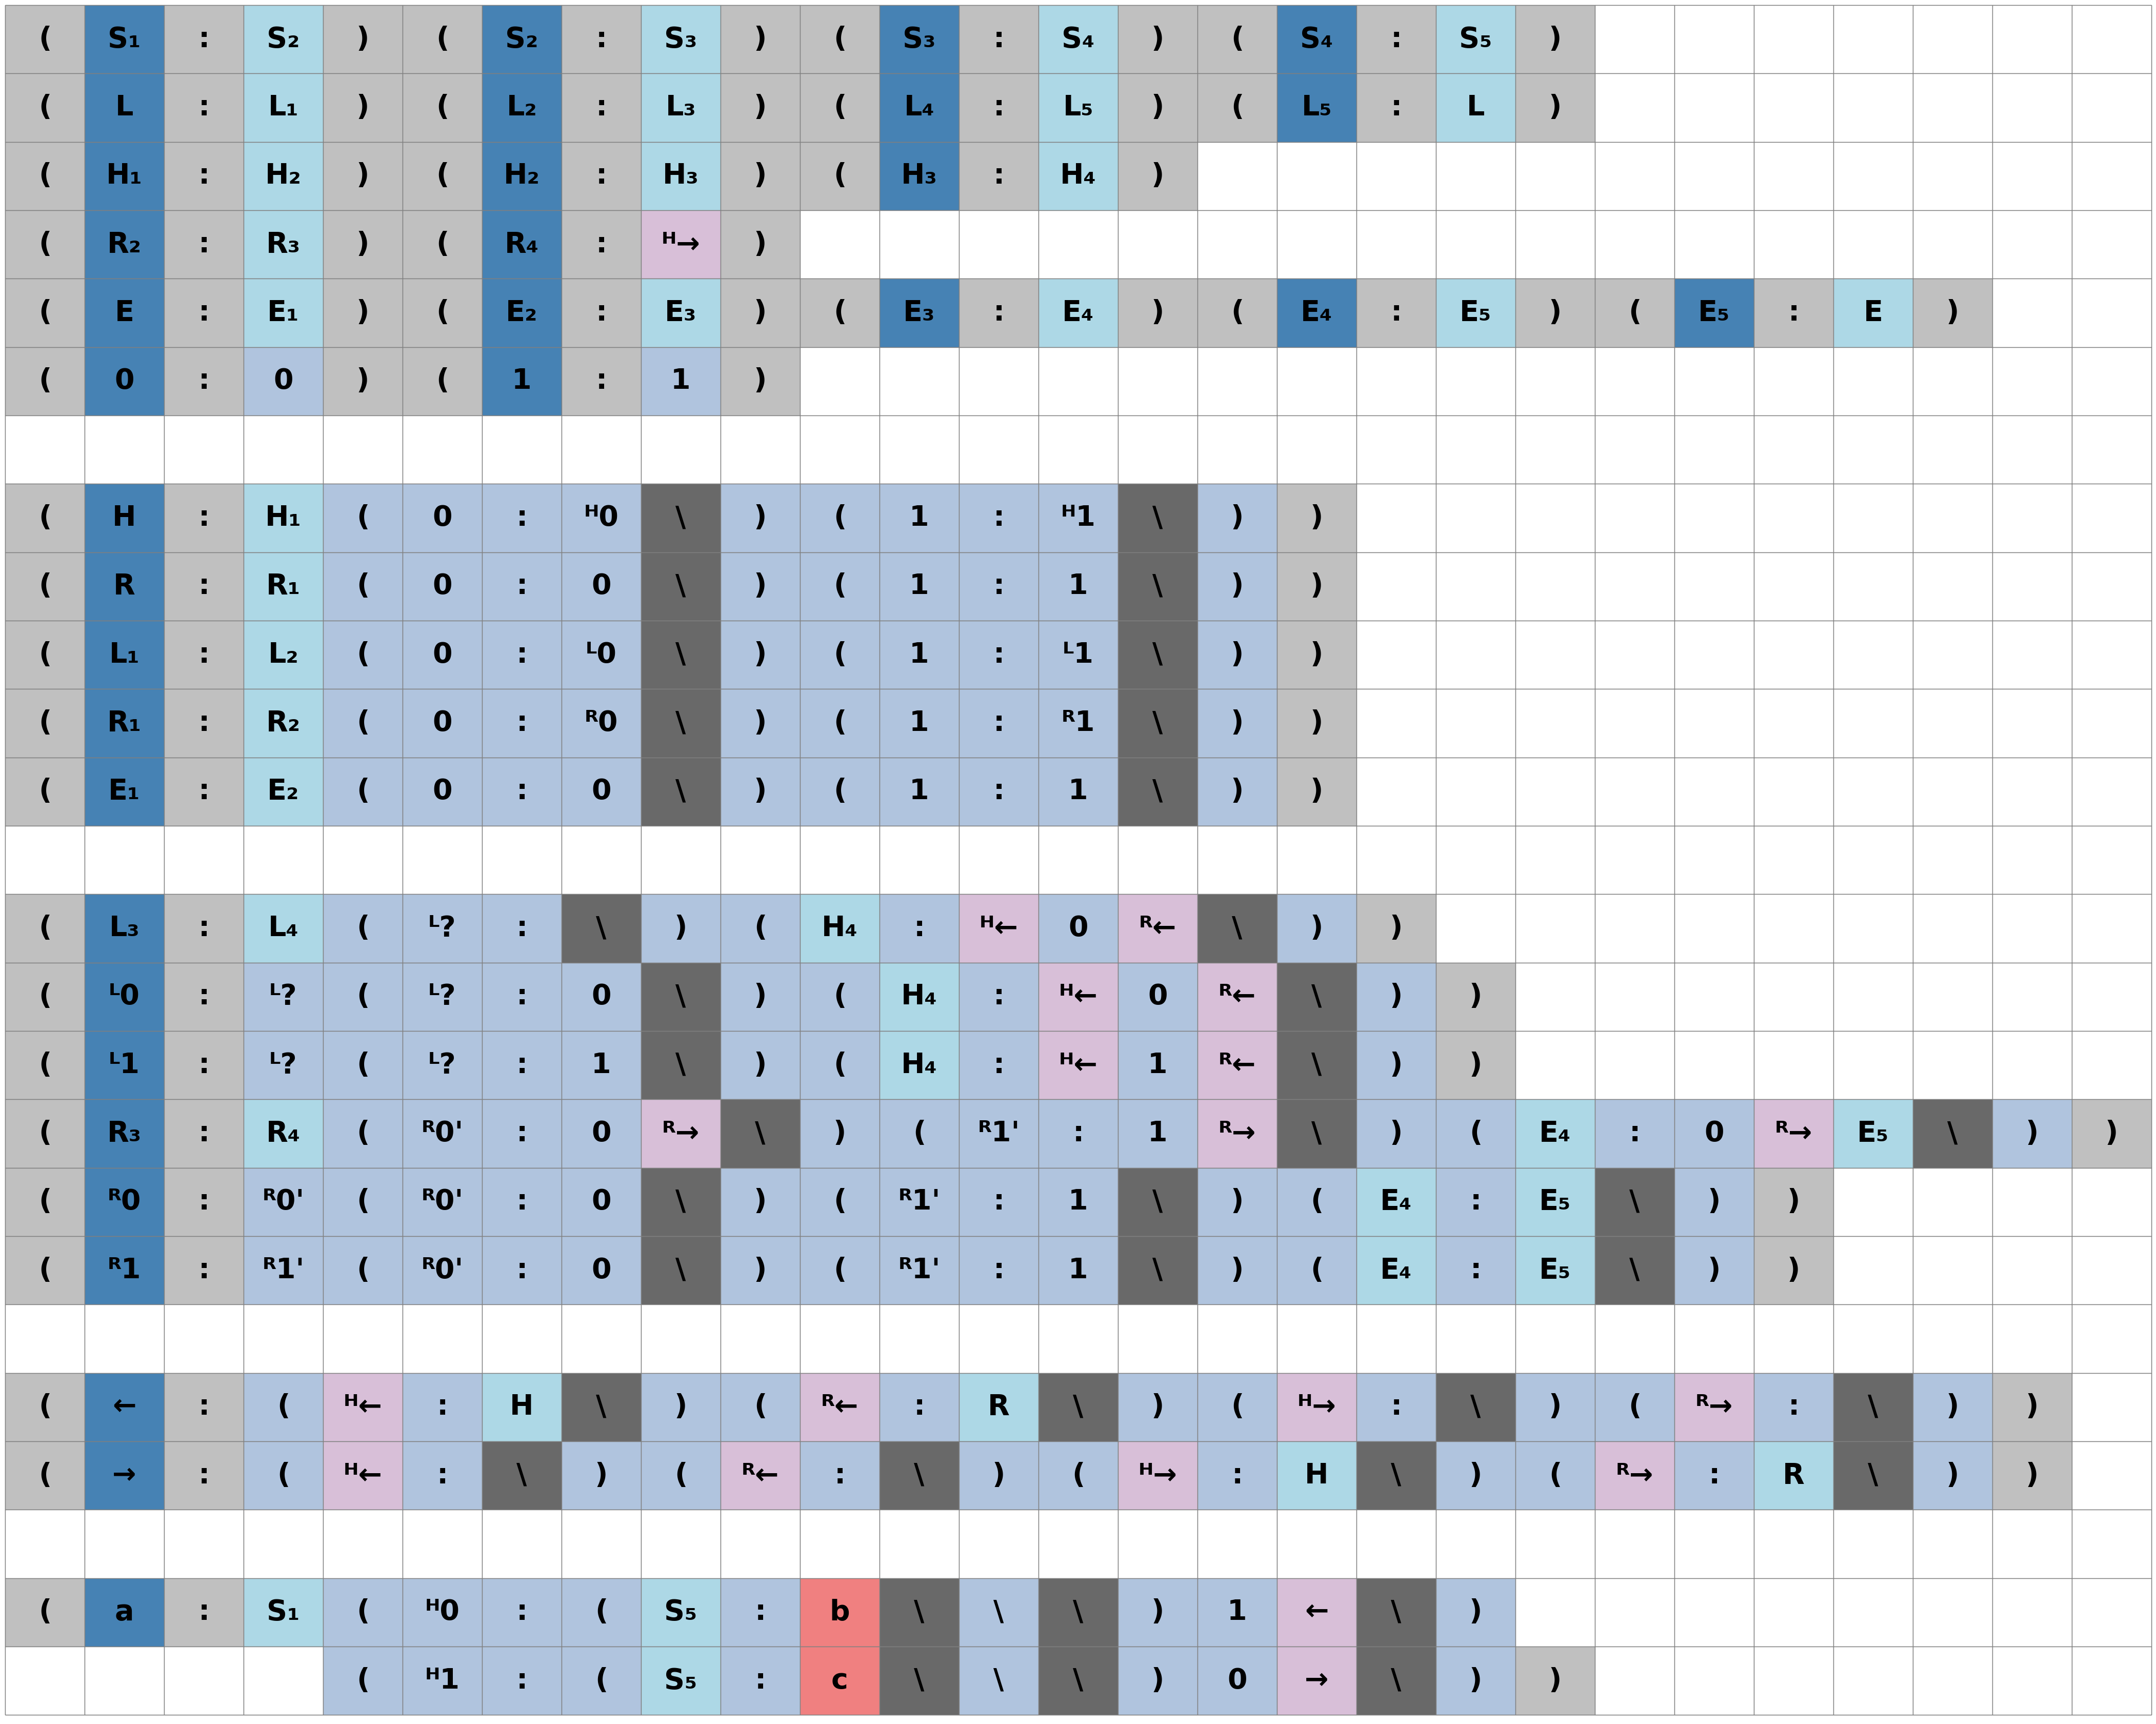

In [72]:
run("""
# Turing Machine
# (a,0) --> (b,1,<)
# (a,1) --> (c,0,>)

( S₁ : S₂ ) ( S₂ : S₃ ) ( S₃ : S₄ ) ( S₄ : S₅ )
( L : L₁ ) ( L₂ : L₃ ) ( L₄ : L₅ ) ( L₅ : L )
( H₁ : ▣ H₂ ) ( H₂ : ▣ H₃ ) ( H₃ : ▣ H₄ ) 
( R₂ : R₃ ) ( R₄ : ᴴ→ )
( E : E₁ ) ( E₂ : E₃ ) ( E₃ : E₄ ) ( E₄ : E₅ ) ( E₅ : E )
( 0 : 0 ) ( 1 : 1 )
□
( H : ▣ H₁ ( 0 : ᴴ0 \ )  ( 1 : ᴴ1 \ ) )
( R : ▣ R₁ ( 0 : 0 \ ) ( 1 : 1 \ ) )
( L₁ : L₂ ( 0 : ᴸ0 \ ) ( 1 : ᴸ1 \ ) )
( R₁ : ▣ R₂ ( 0 : ᴿ0 \ ) ( 1 : ᴿ1 \ ) )
( E₁ : E₂ ( 0 : 0 \ )   ( 1 : 1 \ ) )
□
( L₃ : L₄ ( ᴸ? : \ ) ( H₄ : ᴴ← 0 ᴿ← \ ) )
( ᴸ0 : ᴸ? ( ᴸ? : 0 \ ) ( H₄ : ᴴ← 0 ᴿ← \ ) )
( ᴸ1 : ᴸ? ( ᴸ? : 1 \ ) ( H₄ : ᴴ← 1 ᴿ← \ ) )
( R₃ : ▣ R₄ ( ᴿ0' : 0 ᴿ→ \ ) ( ᴿ1' : 1 ᴿ→ \ ) ( E₄ : 0 ᴿ→ E₅ \ ) )
( ᴿ0 : ᴿ0' ( ᴿ0' : 0 \ ) ( ᴿ1' : 1 \ ) ( E₄ : E₅ \ ) )
( ᴿ1 : ᴿ1' ( ᴿ0' : 0 \ ) ( ᴿ1' : 1 \ ) ( E₄ : E₅ \ ) )
□
( ← : ( ᴴ← : H \ ) ( ᴿ← : R \ ) ( ᴴ→ : ▣ \ ) ( ᴿ→ : ▣ \ ) )
( → : ( ᴴ← : ▣ \ ) ( ᴿ← : ▣ \ ) ( ᴴ→ : H \ ) ( ᴿ→ : R \ ) )
□
( a : S₁ ( ᴴ0 : ( S₅ : b \ \ \ ) 1 ← \ )      # (a,0) --> (b,1,<)
□ □ □ □ ( ᴴ1 : ( S₅ : c \ \ \ ) 0 → \ ) )      # (a,1) --> (c,0,>)

!SCALE 4
!HIGHLIGHT(lightblue) S₁ S₂ S₃ S₄ S₅ L L₁ L₂ L₃ L₄ L₅ H H₁ H₂ H₃ H₄ H₅ R R₁ R₂ R₃ R₄ R₅ E E₁ E₂ E₃ E₄ E₅
!HIGHLIGHT(thistle) ᴴ← ᴿ← ᴴ→ ᴿ→ ← →
!HIGHLIGHT(lightcoral) a b c
!HIGHLIGHT_IN_RULES
!REPEAT ■
!NEWLINE_TOKENS ■
!EMPTY_TOKENS □ ▣
!SKIP_IN_RULES □ ■

# !SKIP_RULES
# ■ a L 1 0 0 ▣ H 0 ▣ R 0 0 1 E
# !SKIP □
!SKIP ▣
""")

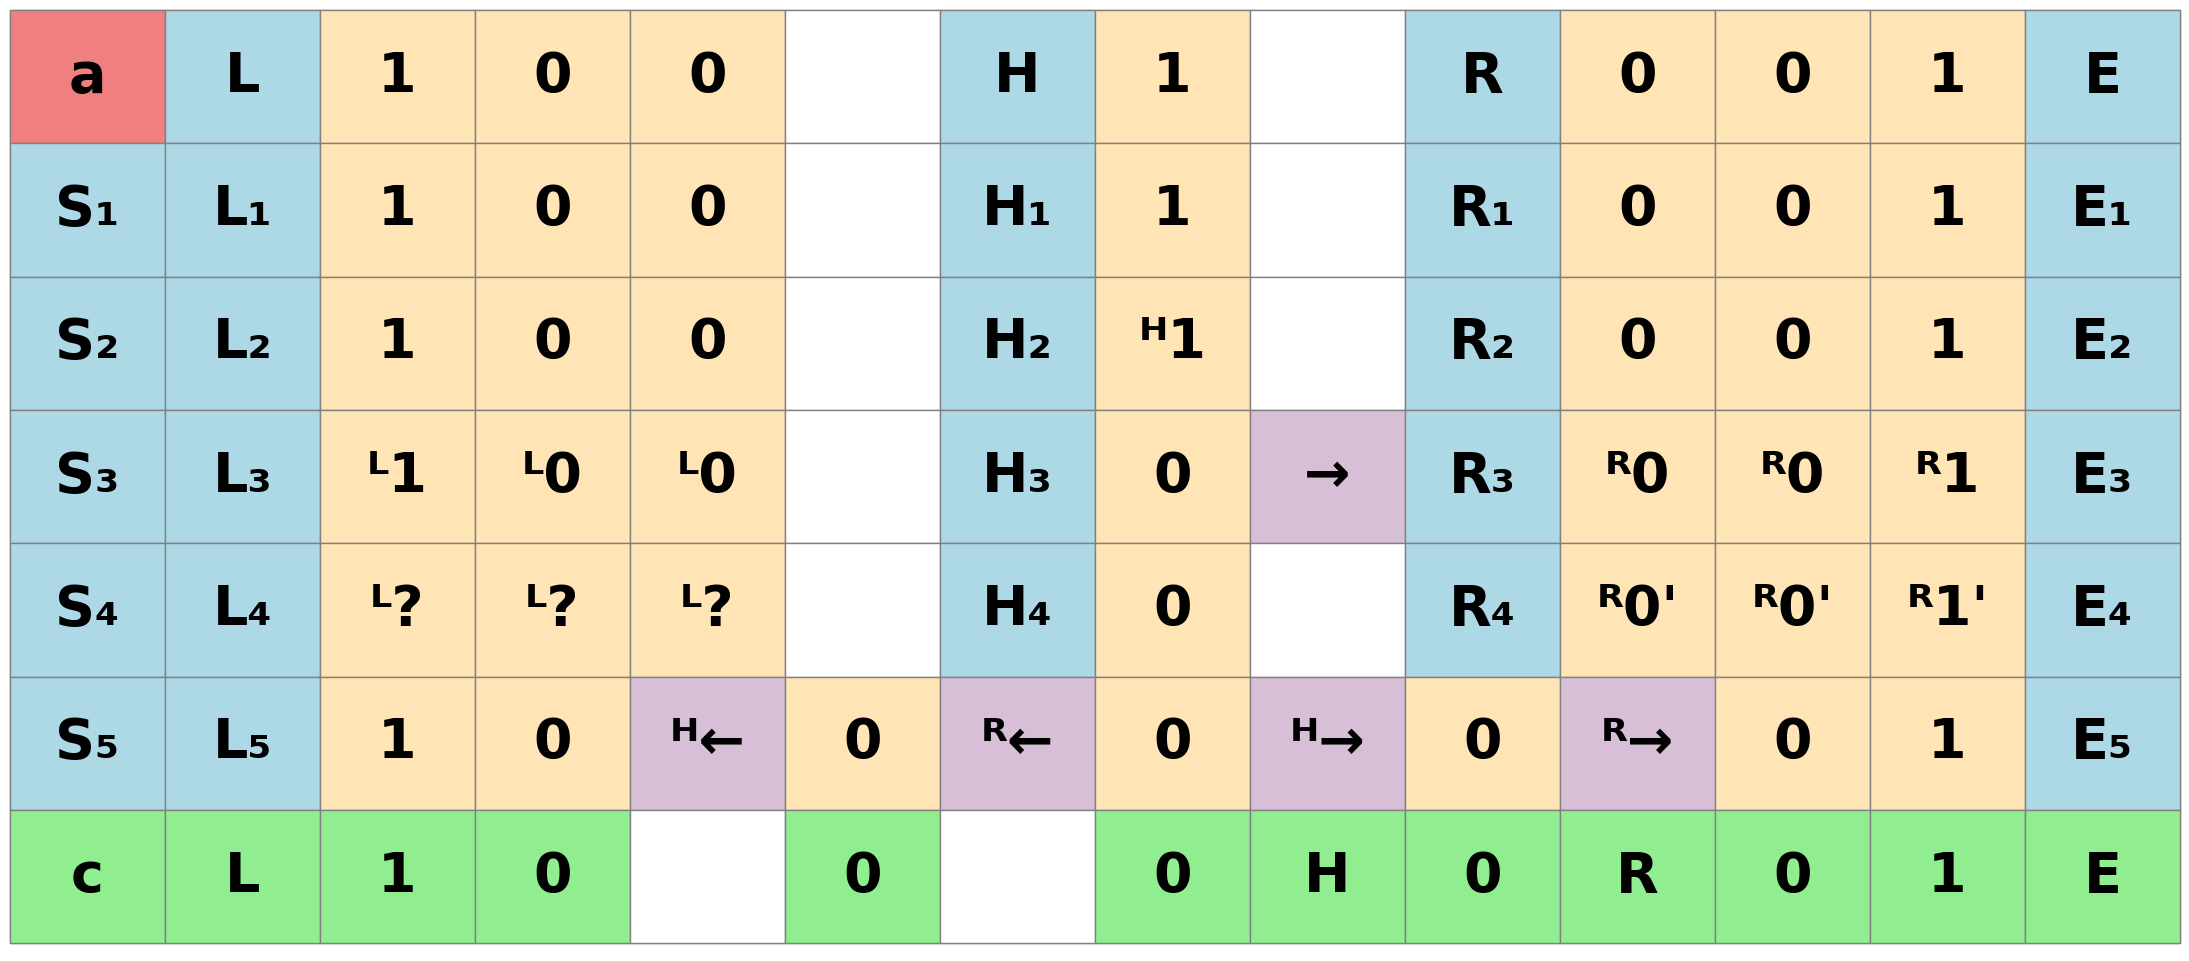

In [128]:
run("""
# Turing Machine
# (a,0) --> (b,1,<)
# (a,1) --> (c,0,>)

( S₁ : S₂ ) ( S₂ : S₃ ) ( S₃ : S₄ ) ( S₄ : S₅ )
( L : L₁ ) ( L₂ : L₃ ) ( L₄ : L₅ ) ( L₅ : L )
( H₁ : ▣ H₂ ) ( H₂ : ▣ H₃ ) ( H₃ : ▣ H₄ ) 
( R₂ : R₃ ) ( R₄ : ᴴ→ )
( E : E₁ ) ( E₂ : E₃ ) ( E₃ : E₄ ) ( E₄ : E₅ ) ( E₅ : E )
( 0 : 0 ) ( 1 : 1 )
□
( H : ▣ H₁ ( 0 : ᴴ0 \ )  ( 1 : ᴴ1 \ ) )
( R : ▣ R₁ ( 0 : 0 \ ) ( 1 : 1 \ ) )
( L₁ : L₂ ( 0 : ᴸ0 \ ) ( 1 : ᴸ1 \ ) )
( R₁ : ▣ R₂ ( 0 : ᴿ0 \ ) ( 1 : ᴿ1 \ ) )
( E₁ : E₂ ( 0 : 0 \ )   ( 1 : 1 \ ) )
□
( L₃ : L₄ ( ᴸ? : \ ) ( H₄ : ᴴ← 0 ᴿ← \ ) )
( ᴸ0 : ᴸ? ( ᴸ? : 0 \ ) ( H₄ : ᴴ← 0 ᴿ← \ ) )
( ᴸ1 : ᴸ? ( ᴸ? : 1 \ ) ( H₄ : ᴴ← 1 ᴿ← \ ) )
( R₃ : ▣ R₄ ( ᴿ0' : 0 ᴿ→ \ ) ( ᴿ1' : 1 ᴿ→ \ ) ( E₄ : 0 ᴿ→ E₅ \ ) )
( ᴿ0 : ᴿ0' ( ᴿ0' : 0 \ ) ( ᴿ1' : 1 \ ) ( E₄ : E₅ \ ) )
( ᴿ1 : ᴿ1' ( ᴿ0' : 0 \ ) ( ᴿ1' : 1 \ ) ( E₄ : E₅ \ ) )
□
( ← : ( ᴴ← : H \ ) ( ᴿ← : R \ ) ( ᴴ→ : ▣ \ ) ( ᴿ→ : ▣ \ ) )
( → : ( ᴴ← : ▣ \ ) ( ᴿ← : ▣ \ ) ( ᴴ→ : H \ ) ( ᴿ→ : R \ ) )
□
( a : S₁ ( ᴴ0 : ( S₅ : b \ \ \ ) 1 ← \ )      # (a,0) --> (b,1,<)
□ □ □ □ ( ᴴ1 : ( S₅ : c \ \ \ ) 0 → \ ) )      # (a,1) --> (c,0,>)

!SCALE 4
!HIGHLIGHT(lightblue) S₁ S₂ S₃ S₄ S₅ L L₁ L₂ L₃ L₄ L₅ H H₁ H₂ H₃ H₄ H₅ R R₁ R₂ R₃ R₄ R₅ E E₁ E₂ E₃ E₄ E₅
!HIGHLIGHT(thistle) ᴴ← ᴿ← ᴴ→ ᴿ→ ← →
!HIGHLIGHT(lightcoral) a b c
!REPEAT ■
!NEWLINE_TOKENS ■
!EMPTY_TOKENS ▣
!SKIP_IN_RULES ■

!SKIP_RULES
■ a L 1 0 0 ▣ H 1 ▣ R 0 0 1 E
!SKIP □
""")

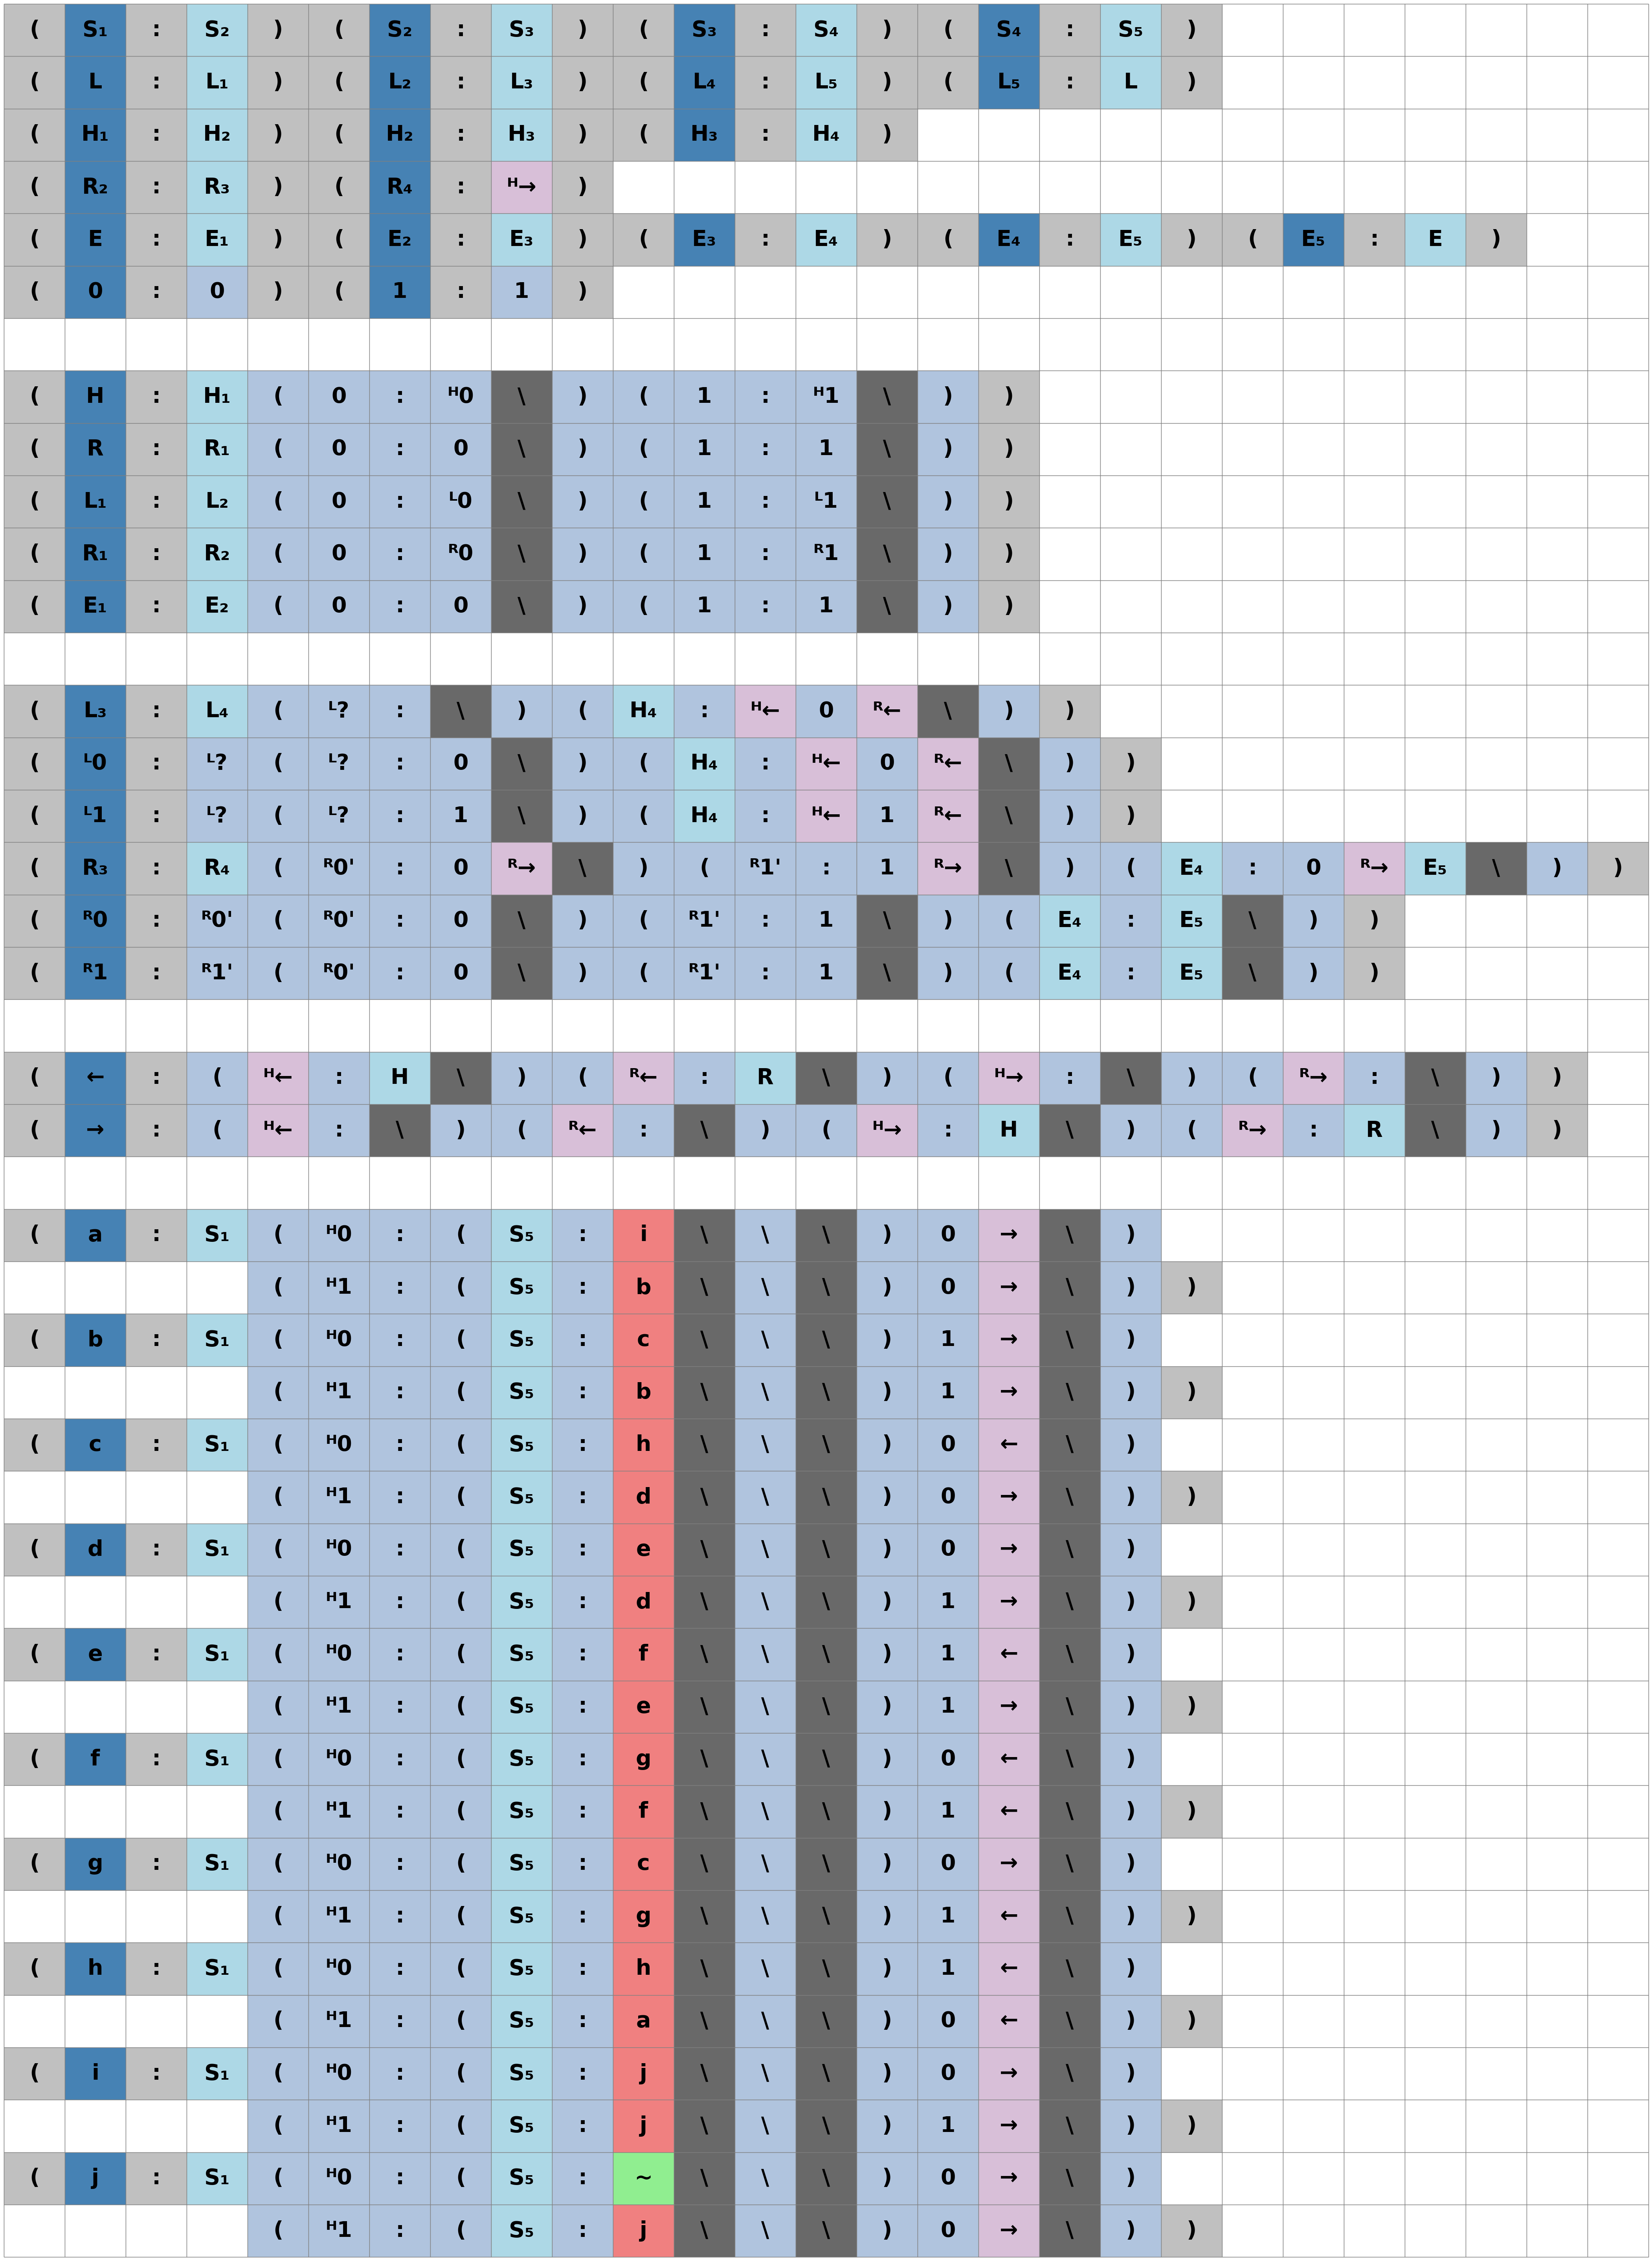

In [75]:
run("""
( S₁ : S₂ ) ( S₂ : S₃ ) ( S₃ : S₄ ) ( S₄ : S₅ )
( L : L₁ ) ( L₂ : L₃ ) ( L₄ : L₅ ) ( L₅ : L )
( H₁ : ▣ H₂ ) ( H₂ : ▣ H₃ ) ( H₃ : ▣ H₄ ) 
( R₂ : R₃ ) ( R₄ : ᴴ→ )
( E : E₁ ) ( E₂ : E₃ ) ( E₃ : E₄ ) ( E₄ : E₅ ) ( E₅ : E )
( 0 : 0 ) ( 1 : 1 )
□
( H : ▣ H₁ ( 0 : ᴴ0 \ )  ( 1 : ᴴ1 \ ) )
( R : ▣ R₁ ( 0 : 0 \ ) ( 1 : 1 \ ) )
( L₁ : L₂ ( 0 : ᴸ0 \ ) ( 1 : ᴸ1 \ ) )
( R₁ : ▣ R₂ ( 0 : ᴿ0 \ ) ( 1 : ᴿ1 \ ) )
( E₁ : E₂ ( 0 : 0 \ )   ( 1 : 1 \ ) )
□
( L₃ : L₄ ( ᴸ? : \ ) ( H₄ : ᴴ← 0 ᴿ← \ ) )
( ᴸ0 : ᴸ? ( ᴸ? : 0 \ ) ( H₄ : ᴴ← 0 ᴿ← \ ) )
( ᴸ1 : ᴸ? ( ᴸ? : 1 \ ) ( H₄ : ᴴ← 1 ᴿ← \ ) )
( R₃ : ▣ R₄ ( ᴿ0' : 0 ᴿ→ \ ) ( ᴿ1' : 1 ᴿ→ \ ) ( E₄ : 0 ᴿ→ E₅ \ ) )
( ᴿ0 : ᴿ0' ( ᴿ0' : 0 \ ) ( ᴿ1' : 1 \ ) ( E₄ : E₅ \ ) )
( ᴿ1 : ᴿ1' ( ᴿ0' : 0 \ ) ( ᴿ1' : 1 \ ) ( E₄ : E₅ \ ) )
□
( ← : ( ᴴ← : H \ ) ( ᴿ← : R \ ) ( ᴴ→ : ▣ \ ) ( ᴿ→ : ▣ \ ) )
( → : ( ᴴ← : ▣ \ ) ( ᴿ← : ▣ \ ) ( ᴴ→ : H \ ) ( ᴿ→ : R \ ) )
□
( a : S₁ ( ᴴ0 : ( S₅ : i \ \ \ ) 0 → \ )        # (a) 0 --> (0, i, >)
 □ □ □ □ ( ᴴ1 : ( S₅ : b \ \ \ ) 0 → \ ) )      # (a) 1 --> (0, b, >)
( b : S₁ ( ᴴ0 : ( S₅ : c \ \ \ ) 1 → \ )        # (b) 0 --> (1, c, >)
 □ □ □ □ ( ᴴ1 : ( S₅ : b \ \ \ ) 1 → \ ) )      # (b) 1 --> (1, b, >)
( c : S₁ ( ᴴ0 : ( S₅ : h \ \ \ ) 0 ← \ )        # (c) 0 --> (0, h, <)
 □ □ □ □ ( ᴴ1 : ( S₅ : d \ \ \ ) 0 → \ ) )      # (c) 1 --> (0, d, >)
( d : S₁ ( ᴴ0 : ( S₅ : e \ \ \ ) 0 → \ )        # (d) 0 --> (0, e, >)
 □ □ □ □ ( ᴴ1 : ( S₅ : d \ \ \ ) 1 → \ ) )      # (d) 1 --> (1, d, >)
( e : S₁ ( ᴴ0 : ( S₅ : f \ \ \ ) 1 ← \ )        # (e) 0 --> (1, f, <)
 □ □ □ □ ( ᴴ1 : ( S₅ : e \ \ \ ) 1 → \ ) )      # (e) 1 --> (1, e, >)
( f : S₁ ( ᴴ0 : ( S₅ : g \ \ \ ) 0 ← \ )        # (f) 0 --> (0, g, <)
 □ □ □ □ ( ᴴ1 : ( S₅ : f \ \ \ ) 1 ← \ ) )      # (f) 1 --> (1, f, <)
( g : S₁ ( ᴴ0 : ( S₅ : c \ \ \ ) 0 → \ )        # (g) 0 --> (0, c, >)
 □ □ □ □ ( ᴴ1 : ( S₅ : g \ \ \ ) 1 ← \ ) )      # (g) 1 --> (1, g, <)
( h : S₁ ( ᴴ0 : ( S₅ : h \ \ \ ) 1 ← \ )        # (h) 0 --> (1, h, <)
 □ □ □ □ ( ᴴ1 : ( S₅ : a \ \ \ ) 0 ← \ ) )      # (h) 1 --> (0, a, <)
( i : S₁ ( ᴴ0 : ( S₅ : j \ \ \ ) 0 → \ )        # (i) 0 --> (0, j, >)
 □ □ □ □ ( ᴴ1 : ( S₅ : j \ \ \ ) 1 → \ ) )      # (i) 1 --> (1, j, >)
( j : S₁ ( ᴴ0 : ( S₅ : ~ \ \ \ ) 0 → \ )        # (j) 0 --> (0, ~, >)
 □ □ □ □ ( ᴴ1 : ( S₅ : j \ \ \ ) 0 → \ ) )      # (j) 1 --> (0, j, >)       

!SCALE 4
!HIGHLIGHT(lightblue) S₁ S₂ S₃ S₄ S₅ L L₁ L₂ L₃ L₄ L₅ H H₁ H₂ H₃ H₄ H₅ R R₁ R₂ R₃ R₄ R₅ E E₁ E₂ E₃ E₄ E₅
!HIGHLIGHT(thistle) ᴴ← ᴿ← ᴴ→ ᴿ→ ← →
!HIGHLIGHT(lightcoral) a b c d e f g h i j
!HIGHLIGHT(lightgreen) ~
!HIGHLIGHT_IN_RULES
!REPEAT ■
!NEWLINE_TOKENS ■
!EMPTY_TOKENS □ ▣
!SKIP_IN_RULES □ ■
!SKIP ▣

""")

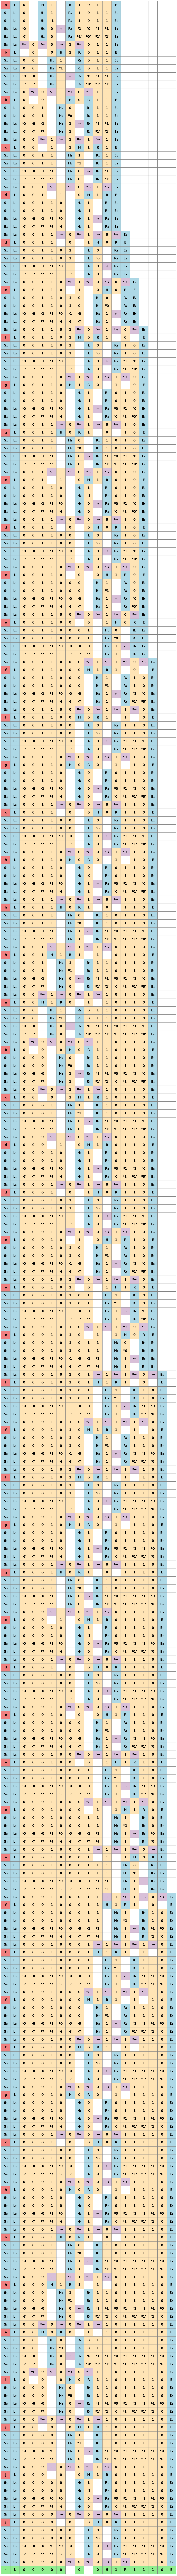

In [70]:
run("""
( S₁ : S₂ ) ( S₂ : S₃ ) ( S₃ : S₄ ) ( S₄ : S₅ )
( L : L₁ ) ( L₂ : L₃ ) ( L₄ : L₅ ) ( L₅ : L )
( H₁ : ▣ H₂ ) ( H₂ : ▣ H₃ ) ( H₃ : ▣ H₄ ) 
( R₂ : R₃ ) ( R₄ : ᴴ→ )
( E : E₁ ) ( E₂ : E₃ ) ( E₃ : E₄ ) ( E₄ : E₅ ) ( E₅ : E )
( 0 : 0 ) ( 1 : 1 )
□
( H : ▣ H₁ ( 0 : ᴴ0 \ )  ( 1 : ᴴ1 \ ) )
( R : ▣ R₁ ( 0 : 0 \ ) ( 1 : 1 \ ) )
( L₁ : L₂ ( 0 : ᴸ0 \ ) ( 1 : ᴸ1 \ ) )
( R₁ : ▣ R₂ ( 0 : ᴿ0 \ ) ( 1 : ᴿ1 \ ) )
( E₁ : E₂ ( 0 : 0 \ )   ( 1 : 1 \ ) )
□
( L₃ : L₄ ( ᴸ? : \ ) ( H₄ : ᴴ← 0 ᴿ← \ ) )
( ᴸ0 : ᴸ? ( ᴸ? : 0 \ ) ( H₄ : ᴴ← 0 ᴿ← \ ) )
( ᴸ1 : ᴸ? ( ᴸ? : 1 \ ) ( H₄ : ᴴ← 1 ᴿ← \ ) )
( R₃ : ▣ R₄ ( ᴿ0' : 0 ᴿ→ \ ) ( ᴿ1' : 1 ᴿ→ \ ) ( E₄ : 0 ᴿ→ E₅ \ ) )
( ᴿ0 : ᴿ0' ( ᴿ0' : 0 \ ) ( ᴿ1' : 1 \ ) ( E₄ : E₅ \ ) )
( ᴿ1 : ᴿ1' ( ᴿ0' : 0 \ ) ( ᴿ1' : 1 \ ) ( E₄ : E₅ \ ) )
□
( ← : ( ᴴ← : H \ ) ( ᴿ← : R \ ) ( ᴴ→ : ▣ \ ) ( ᴿ→ : ▣ \ ) )
( → : ( ᴴ← : ▣ \ ) ( ᴿ← : ▣ \ ) ( ᴴ→ : H \ ) ( ᴿ→ : R \ ) )
□
( a : S₁ ( ᴴ0 : ( S₅ : i \ \ \ ) 0 → \ )        # (a) 0 --> (0, i, >)
 □ □ □ □ ( ᴴ1 : ( S₅ : b \ \ \ ) 0 → \ ) )      # (a) 1 --> (0, b, >)
( b : S₁ ( ᴴ0 : ( S₅ : c \ \ \ ) 1 → \ )        # (b) 0 --> (1, c, >)
 □ □ □ □ ( ᴴ1 : ( S₅ : b \ \ \ ) 1 → \ ) )      # (b) 1 --> (1, b, >)
( c : S₁ ( ᴴ0 : ( S₅ : h \ \ \ ) 0 ← \ )        # (c) 0 --> (0, h, <)
 □ □ □ □ ( ᴴ1 : ( S₅ : d \ \ \ ) 0 → \ ) )      # (c) 1 --> (0, d, >)
( d : S₁ ( ᴴ0 : ( S₅ : e \ \ \ ) 0 → \ )        # (d) 0 --> (0, e, >)
 □ □ □ □ ( ᴴ1 : ( S₅ : d \ \ \ ) 1 → \ ) )      # (d) 1 --> (1, d, >)
( e : S₁ ( ᴴ0 : ( S₅ : f \ \ \ ) 1 ← \ )        # (e) 0 --> (1, f, <)
 □ □ □ □ ( ᴴ1 : ( S₅ : e \ \ \ ) 1 → \ ) )      # (e) 1 --> (1, e, >)
( f : S₁ ( ᴴ0 : ( S₅ : g \ \ \ ) 0 ← \ )        # (f) 0 --> (0, g, <)
 □ □ □ □ ( ᴴ1 : ( S₅ : f \ \ \ ) 1 ← \ ) )      # (f) 1 --> (1, f, <)
( g : S₁ ( ᴴ0 : ( S₅ : c \ \ \ ) 0 → \ )        # (g) 0 --> (0, c, >)
 □ □ □ □ ( ᴴ1 : ( S₅ : g \ \ \ ) 1 ← \ ) )      # (g) 1 --> (1, g, <)
( h : S₁ ( ᴴ0 : ( S₅ : h \ \ \ ) 1 ← \ )        # (h) 0 --> (1, h, <)
 □ □ □ □ ( ᴴ1 : ( S₅ : a \ \ \ ) 0 ← \ ) )      # (h) 1 --> (0, a, <)
( i : S₁ ( ᴴ0 : ( S₅ : j \ \ \ ) 0 → \ )        # (i) 0 --> (0, j, >)
 □ □ □ □ ( ᴴ1 : ( S₅ : j \ \ \ ) 1 → \ ) )      # (i) 1 --> (1, j, >)
( j : S₁ ( ᴴ0 : ( S₅ : ~ \ \ \ ) 0 → \ )        # (j) 0 --> (0, ~, >)
 □ □ □ □ ( ᴴ1 : ( S₅ : j \ \ \ ) 0 → \ ) )      # (j) 1 --> (0, j, >)       

!HIGHLIGHT(lightblue) S₁ S₂ S₃ S₄ S₅ L L₁ L₂ L₃ L₄ L₅ H H₁ H₂ H₃ H₄ H₅ R R₁ R₂ R₃ R₄ R₅ E E₁ E₂ E₃ E₄ E₅
!HIGHLIGHT(thistle) ᴴ← ᴿ← ᴴ→ ᴿ→ ← →
!HIGHLIGHT(lightcoral) a b c d e f g h i j
!REPEAT ■
!NEWLINE_TOKENS ■
!EMPTY_TOKENS □ ▣
!SKIP_IN_RULES □ ■
!SCALE 2

!SKIP_RULES
■ a L 0 ▣ H 1 ▣ R 1 0 1 1 E
!SKIP □

# !LIMIT 2500

""")